In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectFromModel



from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

In [2]:
# Load NSL-KDD dataset ( Encoded and Important Features only)
df = pd.read_csv('imp_final_df.csv')

# Display the first few rows of the dataset to understand its structure


print('originail shape:', df.shape)

df.head()


originail shape: (125973, 26)


src_bytes  dst_bytes  same_srv_rate  diff_srv_rate  flag_SF  \
0        491          0           1.00           0.00     True   
1        146          0           0.08           0.15     True   
2          0          0           0.05           0.07    False   
3        232       8153           1.00           0.00     True   
4        199        420           1.00           0.00     True   

   dst_host_srv_count  dst_host_same_srv_rate  logged_in  \
0                  25                    0.17          0   
1                   1                    0.00          0   
2                  26                    0.10          0   
3                 255                    1.00          1   
4                 255                    1.00          1   

   dst_host_serror_rate  dst_host_diff_srv_rate  ...  \
0                  0.00                    0.03  ...   
1                  0.00                    0.60  ...   
2                  1.00                    0.05  ...   
3                  0.03                    0.00  ...   
4                  0.00                    0.00  ...   

   dst_host_srv_diff_host_rate  level  dst_host_count  \
0                         0.00     20             150   
1                         0.00     15             255   
2                         0.00     19             255   
3                         0.04     21              30   
4                         0.00     21             255   

   dst_host_same_src_port_rate  service_private  srv_diff_host_rate  \
0                         0.17            False                0.00   
1                         0.88            False                0.00   
2                         0.00             True                0.00   
3                         0.03            False                0.00   
4                         0.00            False                0.09   

   srv_count  dst_host_srv_rerror_rate  service_domain_u  target  
0          2                      0.00             False       0  
1          1                      0.00             False       0  
2          6                      0.00             False       1  
3          5                      0.01             False       0  
4         32                      0.00             False       0  

[5 rows x 26 columns]

In [3]:
# Split the data into features and target
X = df.drop(columns=['target'])
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 1. CTGAN

In [4]:
# CTGAN
# Import necessary packages
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.stats as stats

# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# CTGAN
ctgan = CTGANSynthesizer(metadata)
ctgan.fit(df)
data_ctgan = ctgan.sample(len(df))
#X_ctgan = synthetic_data.drop(columns='target').values
#y_ctgan = synthetic_data['target'].values

#X = data.drop(columns=['target'])
#y = data['target']

#df_ctgan = pd.DataFrame(X_ctgan, columns=X.columns)
#df_ctgan['target'] = y_ctgan

data_ctgan.head()

c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:92: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


src_bytes  dst_bytes  same_srv_rate  diff_srv_rate  flag_SF  \
0          0          0           0.04           0.05    False   
1          0       3367           1.00           0.00     True   
2          0       2791           1.00           0.00     True   
3      12584          0           1.00           0.00     True   
4       6874       4416           1.00           0.00     True   

   dst_host_srv_count  dst_host_same_srv_rate  logged_in  \
0                  17                    0.06          0   
1                 255                    1.00          1   
2                 255                    1.00          1   
3                 172                    0.55          1   
4                 255                    1.00          1   

   dst_host_serror_rate  dst_host_diff_srv_rate  ...  \
0                   1.0                    0.05  ...   
1                   0.0                    0.00  ...   
2                   0.0                    0.00  ...   
3                   0.0                    0.08  ...   
4                   0.0                    0.00  ...   

   dst_host_srv_diff_host_rate  level  dst_host_count  \
0                         0.00     21             255   
1                         0.05     21              15   
2                         0.03     21              12   
3                         0.01     21              29   
4                         0.02     21              37   

   dst_host_same_src_port_rate  service_private  srv_diff_host_rate  \
0                         0.00             True                0.00   
1                         0.04            False                0.08   
2                         0.50            False                0.00   
3                         0.05            False                1.00   
4                         0.01            False                0.07   

   srv_count  dst_host_srv_rerror_rate  service_domain_u  target  
0         23                       0.0             False       1  
1         17                       0.0             False       0  
2          3                       0.0             False       0  
3          1                       0.0             False       0  
4         48                       0.0             False       0  

[5 rows x 26 columns]

In [5]:
data_ctgan.to_csv('data_ctgan.csv', index = False)

# 2. GANBLR++

In [6]:
#pip install ganblr

In [7]:
#from ganblr import get_demo_data
from ganblr.models import GANBLRPP

# to have the same datatype
def is_numerical(dtype):
    return dtype.kind in 'iuf'

# Check for numerical columns in the features only (exclude target column)
column_is_numerical = df.iloc[:, :-1].dtypes.apply(is_numerical).values
numerical_columns = np.argwhere(column_is_numerical).ravel()

# # Ensure numerical_columns are within the bounds of data's feature columns
# if numerical_columns.max() >= df.shape[1] - 1:
#     raise IndexError("Numerical column index out of bounds")

#Initialize the model with the correct numerical columns
model = GANBLRPP(numerical_columns)


# Fit the model
model.fit(df.values[:, :-1], df.values[:, -1], epochs=10)


# Generate synthetic data
synthetic_data = model.sample(1000)
data_ganblrpp = pd.DataFrame(synthetic_data, columns=df.columns)

# Map the data types from the real data to the synthetic data
dtype_mapping = df.dtypes.to_dict()
data_ganblrpp = data_ganblrpp.astype(dtype_mapping)

data_ganblrpp.head()


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


warmup run:




c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 814us/step - accuracy: 0.9525 - loss: 0.1487


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\l

Epoch 1/10: G_loss = 5.785820, G_accuracy = 0.985886, D_loss = 0.224043, D_accuracy = 0.940156


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/10: G_loss = 5.702763, G_accuracy = 0.987791, D_loss = 0.262918, D_accuracy = 0.935274


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 3/10: G_loss = 5.922730, G_accuracy = 0.988545, D_loss = 0.210031, D_accuracy = 0.946000


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 4/10: G_loss = 5.765838, G_accuracy = 0.988894, D_loss = 0.169722, D_accuracy = 0.949711


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 5/10: G_loss = 5.817249, G_accuracy = 0.989363, D_loss = 0.263850, D_accuracy = 0.936762


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 6/10: G_loss = 5.459028, G_accuracy = 0.989506, D_loss = 0.305610, D_accuracy = 0.927315


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 7/10: G_loss = 6.265747, G_accuracy = 0.989720, D_loss = 0.256380, D_accuracy = 0.939014


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 8/10: G_loss = 5.932502, G_accuracy = 0.989966, D_loss = 0.204988, D_accuracy = 0.945494


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 9/10: G_loss = 6.231393, G_accuracy = 0.990006, D_loss = 0.306222, D_accuracy = 0.938206


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


Epoch 10/10: G_loss = 6.030645, G_accuracy = 0.990149, D_loss = 0.324094, D_accuracy = 0.929305
Step 1/2: Sampling discrete data from GANBLR.


Generating for node: 0: 100%|██████████| 26/26 [00:00<00:00, 426.59it/s]
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


step 2/2: Sampling numerical data.


sampling: 100%|██████████| 20/20 [00:00<00:00, 168.93it/s]


src_bytes  dst_bytes  same_srv_rate  diff_srv_rate  flag_SF  \
0    17408832    1624407       0.300324       0.045790     True   
1    -3101420    6688151       0.083298       0.222470     True   
2     4416282    3840782       0.246185       0.055440     True   
3       52978      34363       0.401963       0.041725    False   
4  1013769582       6367       0.386154       0.056443    False   

   dst_host_srv_count  dst_host_same_srv_rate  logged_in  \
0                 215                0.043302          0   
1                 156                1.248739          0   
2                  45                1.396301          0   
3                 105               -0.138936          0   
4                 168                0.899607          0   

   dst_host_serror_rate  dst_host_diff_srv_rate  ...  \
0              0.130252                0.203635  ...   
1              0.027237                0.785805  ...   
2              0.004678                1.005927  ...   
3              0.832317                0.535787  ...   
4              0.004363                0.988835  ...   

   dst_host_srv_diff_host_rate  level  dst_host_count  \
0                     0.230046     17               0   
1                     0.304327      2             133   
2                     0.265613      4             130   
3                     0.151695     20             235   
4                     0.132613      6               8   

   dst_host_same_src_port_rate  service_private  srv_diff_host_rate  \
0                     0.237441             True            0.880094   
1                     0.529889             True            0.645823   
2                     0.909025             True           -0.020536   
3                     0.127678            False            0.282459   
4                     0.556363             True            0.510085   

   srv_count  dst_host_srv_rerror_rate  service_domain_u  target  
0        409                  0.041289             False       1  
1        152                  0.030349             False       1  
2         51                  0.259698             False       1  
3        533                  1.002251              True       0  
4        512                  0.038495             False       1  

[5 rows x 26 columns]

In [8]:
data_ganblrpp.to_csv('data_ganblrpp.csv', index = False)

# 3. Copula GAN

In [9]:
# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# CopulaGan
from sdv.single_table import CopulaGANSynthesizer

copulagan = CopulaGANSynthesizer(metadata)
copulagan.fit(df)

data_copula_gan = copulagan.sample(len(df))
data_copula_gan.head()

INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "columns": {
        "src_bytes": {
            "sdtype": "numerical"
        },
        "dst_bytes": {
            "sdtype": "numerical"
        },
        "same_srv_rate": {
            "sdtype": "numerical"
        },
        "diff_srv_rate": {
            "sdtype": "numerical"
        },
        "flag_SF": {
            "sdtype": "categorical"
        },
        "dst_host_srv_count": {
            "sdtype": "numerical"
        },
        "dst_host_same_srv_rate": {
            "sdtype": "numerical"
        },
        "logged_in": {
            "sdtype": "categorical"
        },
        "dst_host_serror_rate": {
            "sdtype": "numerical"
        },
        "dst_host_diff_srv_rate": {
            "sdtype": "numerical"
        },
        "dst_host_srv_serror_rate": {
            "sdtype": "numerical"
        },
        "serror_rate": {
            "sdtype": "numerical"
        },
        "sr

src_bytes  dst_bytes  same_srv_rate  diff_srv_rate  flag_SF  \
0          0          0           0.14           0.06    False   
1        213       1304           1.00           0.00     True   
2          0          0           1.00           0.00    False   
3        707          8           1.00           0.00     True   
4        283       1687           1.00           0.00     True   

   dst_host_srv_count  dst_host_same_srv_rate  logged_in  \
0                  11                    0.02          0   
1                 255                    1.00          1   
2                 223                    1.00          0   
3                 255                    1.00          0   
4                 255                    1.00          1   

   dst_host_serror_rate  dst_host_diff_srv_rate  ...  \
0                   1.0                    0.06  ...   
1                   0.0                    0.00  ...   
2                   0.0                    0.00  ...   
3                   0.0                    0.00  ...   
4                   0.0                    0.00  ...   

   dst_host_srv_diff_host_rate  level  dst_host_count  \
0                         0.00     21             255   
1                         0.04     21               7   
2                         0.12     21              18   
3                         0.00     18             255   
4                         0.01     21             217   

   dst_host_same_src_port_rate  service_private  srv_diff_host_rate  \
0                         0.00             True                0.00   
1                         0.06            False                0.21   
2                         0.09            False                0.55   
3                         1.00            False                0.00   
4                         0.00            False                0.00   

   srv_count  dst_host_srv_rerror_rate  service_domain_u  target  
0          4                      0.00             False       1  
1         11                      0.00             False       0  
2          2                      0.67             False       0  
3        322                      0.00             False       1  
4          4                      0.00             False       0  

[5 rows x 26 columns]

In [10]:
data_copula_gan.to_csv('data_copula_gan.csv', index = False)

In [11]:
# 4. CASTGAN

In [13]:
data_castgan = pd.read_csv("data_castgan.csv")
data_castgan.head()

src_bytes  dst_bytes  same_srv_rate  diff_srv_rate  flag_SF  \
0       2949     -10144       0.998091      -0.000259     True   
1      -9947      -5026       0.998359      -0.000837     True   
2      -9625      -1744       0.097352       0.083104     True   
3       1718      -4454       0.997418      -0.001029     True   
4     -12353        762       1.006028       0.000689     True   

   dst_host_srv_count  dst_host_same_srv_rate  logged_in  \
0                 252                1.000233          1   
1                 252                1.005390          0   
2                 251                0.125089          0   
3                  24                0.999555          0   
4                  28                0.991277          0   

   dst_host_serror_rate  dst_host_diff_srv_rate  ...  \
0             -0.002835               -0.002221  ...   
1              0.000064               -0.000089  ...   
2             -0.000744                0.070955  ...   
3             -0.001780                0.029461  ...   
4              0.001197                0.021478  ...   

   dst_host_srv_diff_host_rate  level  dst_host_count  \
0                     0.024957     20              96   
1                     0.032683     21              39   
2                     0.000180     17             254   
3                     0.002039     17             256   
4                     0.037959     19               0   

   dst_host_same_src_port_rate  service_private  srv_diff_host_rate  \
0                     0.011648            False            0.004272   
1                     0.027538            False            0.005122   
2                    -0.000811            False            0.972419   
3                     0.183254            False            0.003544   
4                     0.988473            False            1.040712   

   srv_count  dst_host_srv_rerror_rate  service_domain_u  target  
0         37                  0.000164             False       0  
1         14                 -0.000137              True       0  
2         22                 -0.000322              True       0  
3         29                  0.001835              True       0  
4          0                 -0.000963             False       1  

[5 rows x 26 columns]

## Correlation Comparison

In [14]:
# Calculate correlation matrices
real_corr = df.corr()
ctgan_corr = data_ctgan.corr()
abs_diff_ctgan_corr= (real_corr - ctgan_corr).abs()

garnblr_corr = data_ganblrpp.corr()
abs_diff_garnblr_corr = (real_corr - garnblr_corr).abs()

copula_corr = data_copula_gan.corr()
abs_diff_copula_corr = (real_corr - copula_corr).abs()

castgan_corr = data_castgan.corr()
abs_diff_castgan_corr = (real_corr - castgan_corr).abs()



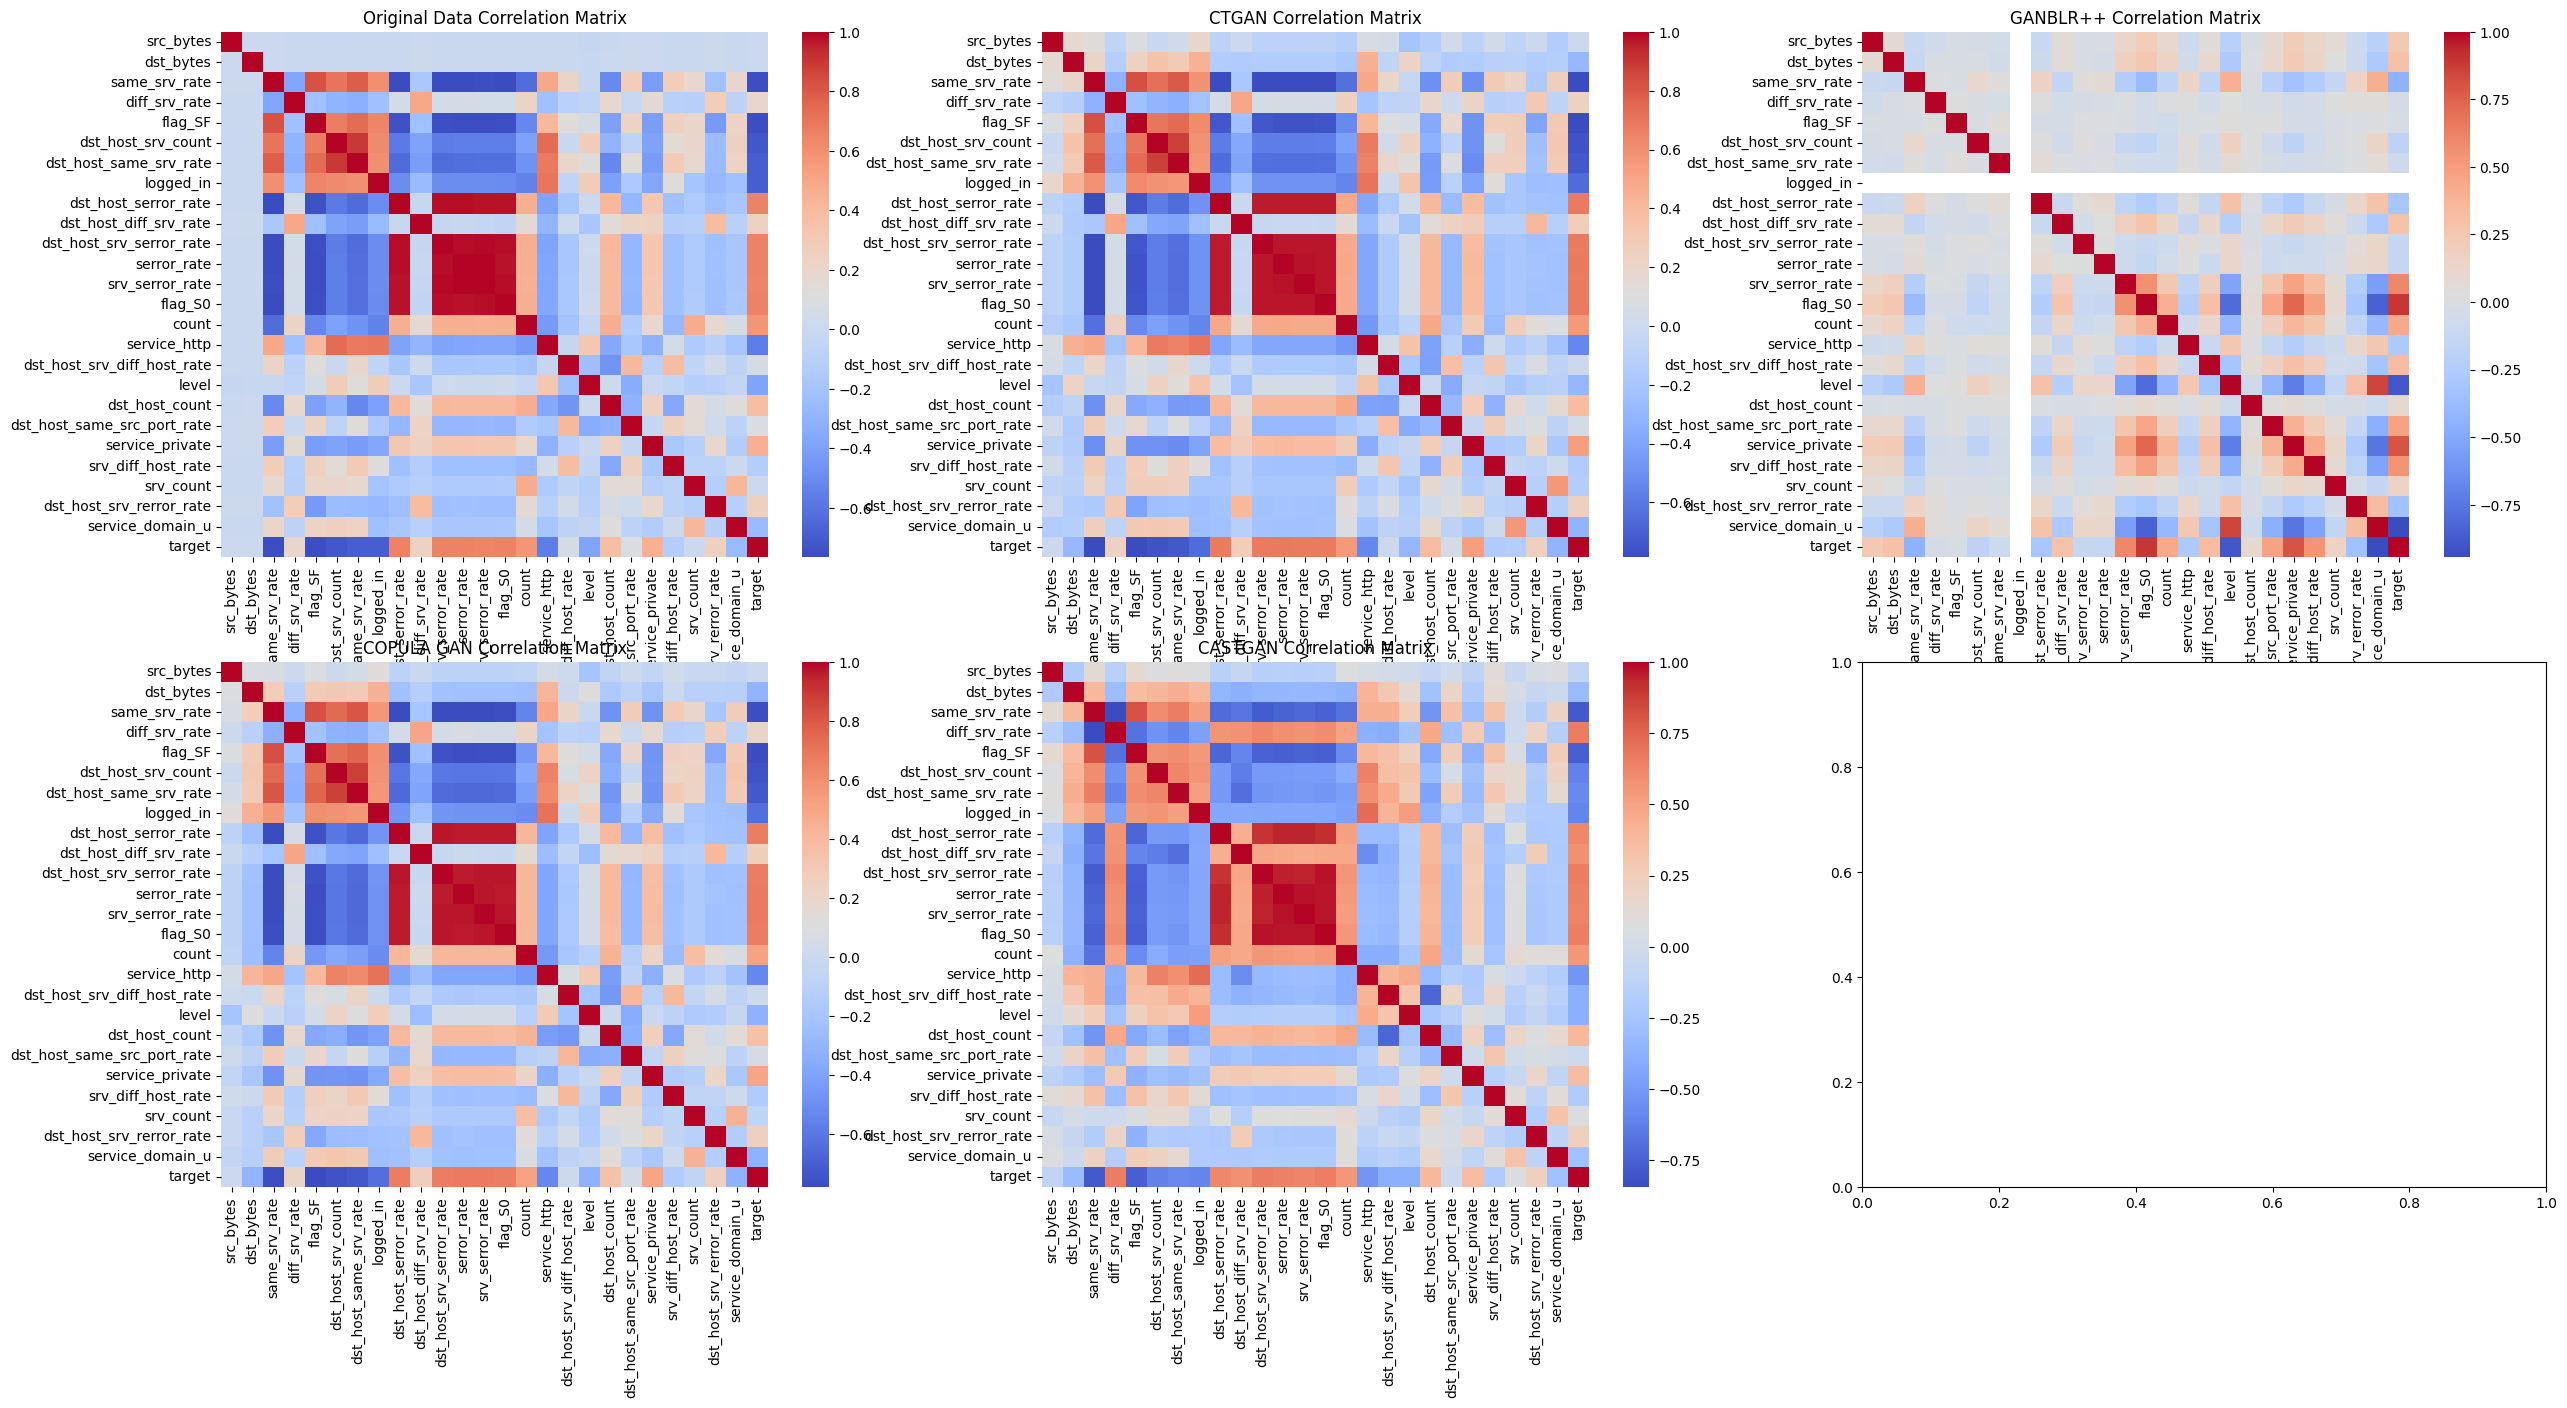

In [15]:
#sns.heatmap(corr, cmap="coolwarm", annot=False, xticklabels=corr.columns, yticklabels=corr.columns)
# Plot the correlation matrix of the original and all oversampled data
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
sns.heatmap(df.corr(), ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=df.corr().columns, yticklabels=df.corr().columns)
axes[0, 0].set_title("Original Data Correlation Matrix")
sns.heatmap(data_ctgan.corr(), ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=data_ctgan.corr().columns, yticklabels=data_ctgan.corr().columns)
axes[0, 1].set_title("CTGAN Correlation Matrix")
sns.heatmap(data_ganblrpp.corr(), ax=axes[0, 2], cmap="coolwarm", annot=False, xticklabels=data_ganblrpp.corr().columns, yticklabels=data_ganblrpp.corr().columns)
axes[0, 2].set_title("GANBLR++ Correlation Matrix")
sns.heatmap(data_copula_gan.corr(), ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=data_copula_gan.corr().columns, yticklabels=data_copula_gan.corr().columns)
axes[1, 0].set_title("COPULA GAN Correlation Matrix")
sns.heatmap(data_castgan.corr(), ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=data_castgan.corr().columns, yticklabels=data_castgan.corr().columns)
axes[1, 1].set_title("CASTGAN Correlation Matrix")
plt.show()

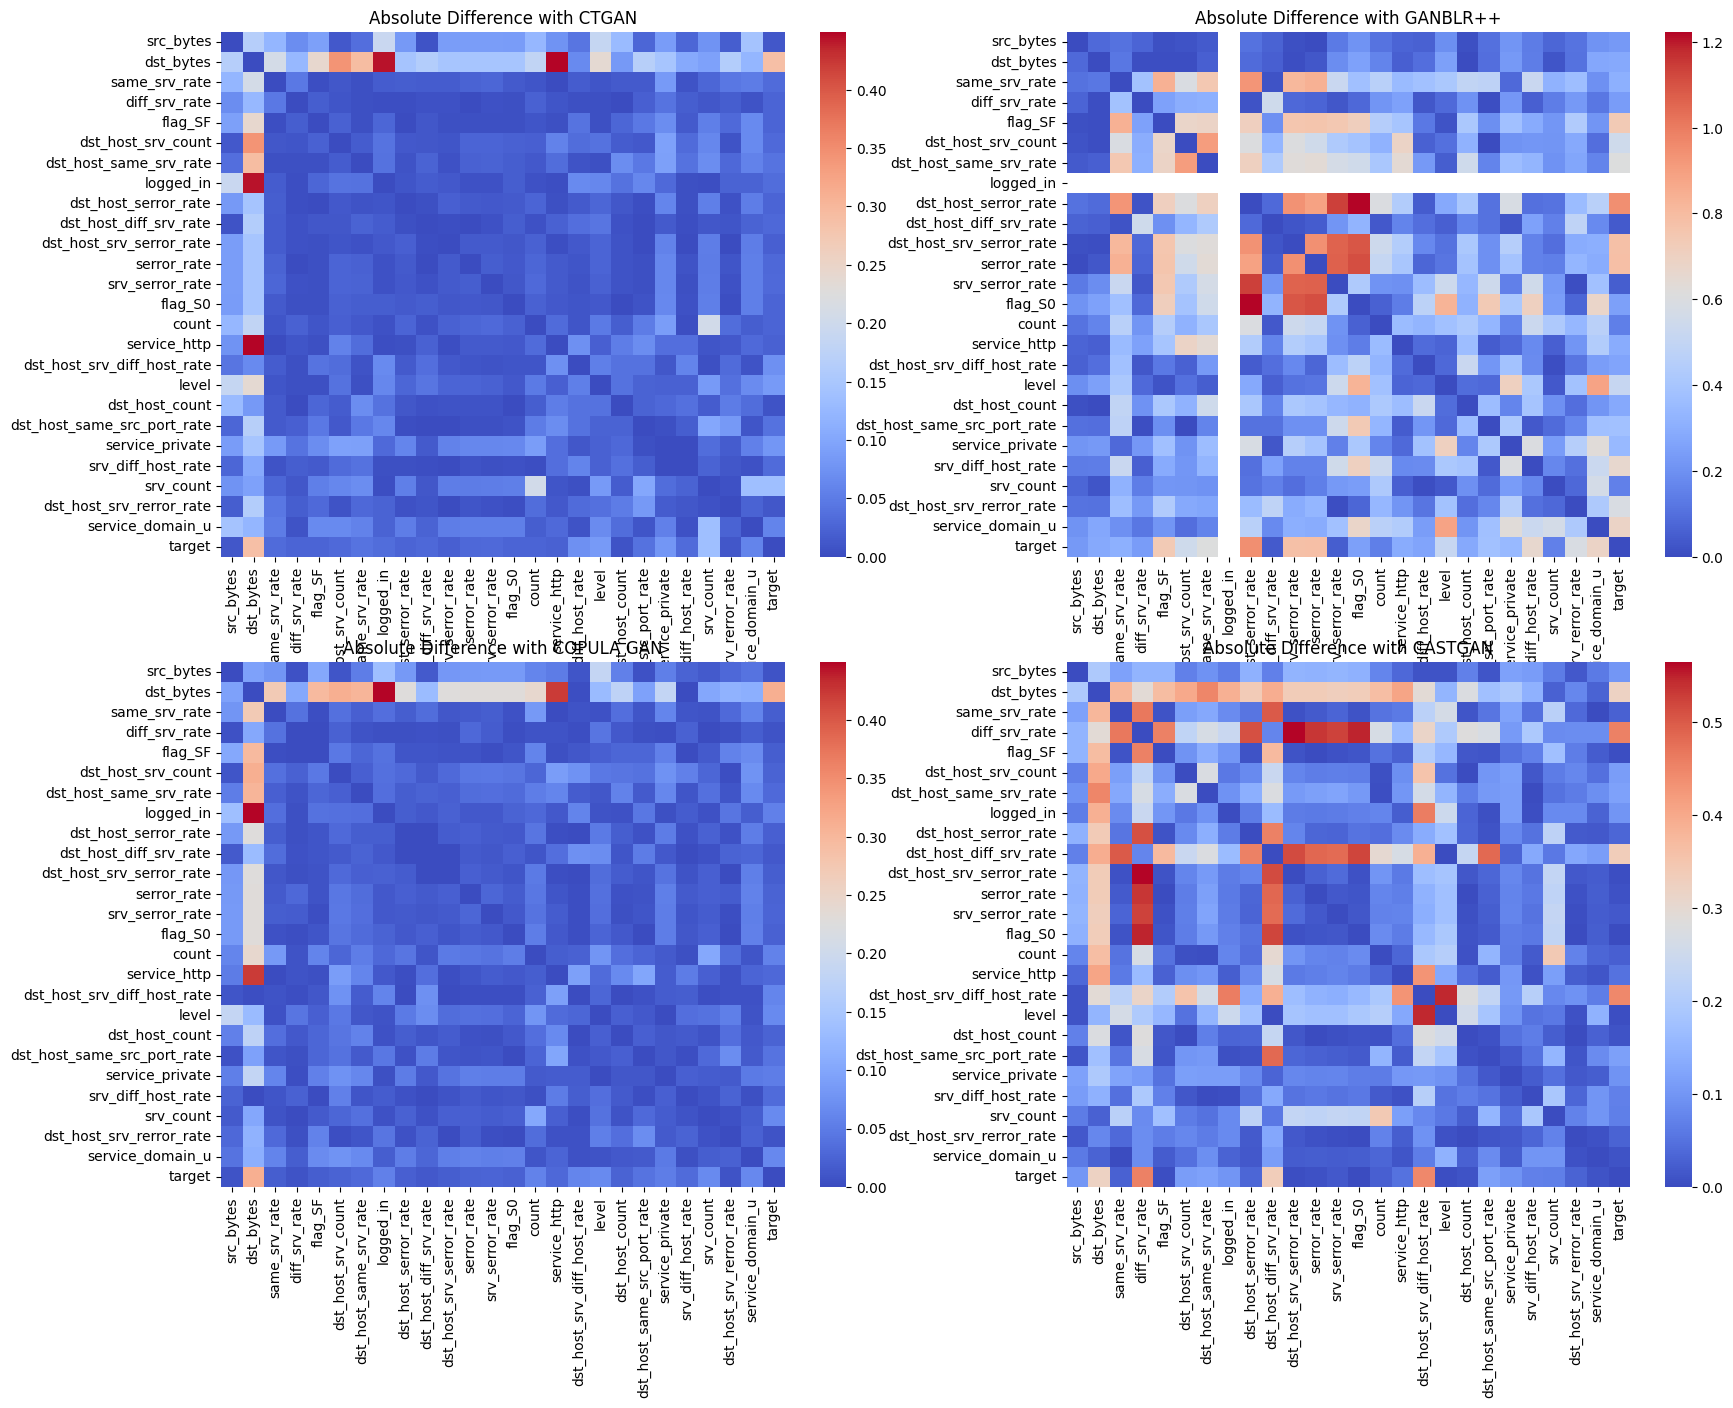

In [16]:

# Plot the absolute difference heatmaps
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.heatmap(abs_diff_ctgan_corr, ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_ctgan_corr.columns, yticklabels=abs_diff_ctgan_corr.columns)
axes[0, 0].set_title("Absolute Difference with CTGAN")
sns.heatmap(abs_diff_garnblr_corr, ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_garnblr_corr.columns, yticklabels=abs_diff_garnblr_corr.columns)
axes[0, 1].set_title("Absolute Difference with GANBLR++")
sns.heatmap(abs_diff_copula_corr, ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_copula_corr.columns, yticklabels=abs_diff_copula_corr.columns)
axes[1, 0].set_title("Absolute Difference with COPULA GAN")
sns.heatmap(abs_diff_castgan_corr, ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_castgan_corr.columns, yticklabels=abs_diff_castgan_corr.columns)
axes[1, 1].set_title("Absolute Difference with CASTGAN")

plt.show()


## Probability Distribution


In [17]:
# Define a function to count columns in each DataFrame
def count_columns(dataframes, titles):
    column_counts = {}
    for df, title in zip(dataframes, titles):
        column_counts[title] = len(df.columns)
    return column_counts


# List of DataFrames
dfs = [df, data_ctgan, data_ganblrpp, data_copula_gan, data_castgan]
titles = ["Original Data", "CTGAN", "GANBLR++", "COPULA GAN", "CASTGAN"]

# Count the columns in each DataFrame
column_counts = count_columns(dfs, titles)

# Print the column counts
for title, count in column_counts.items():
    print(f"{title} has {count} columns.")


Original Data has 26 columns.
CTGAN has 26 columns.
GANBLR++ has 26 columns.
COPULA GAN has 26 columns.
CASTGAN has 26 columns.



--- Average Results ---
Original Data:
Equal Distributions: 25
Different Distributions: 0
Average KS P-value: 1.0
-----------------------------
CTGAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 3.892642134609082e-18
-----------------------------
GANBLR++:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 2.7424431783230867e-14
-----------------------------
COPULA GAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 4.123941951749359e-11
-----------------------------
CASTGAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 0.0019239474804304685
-----------------------------


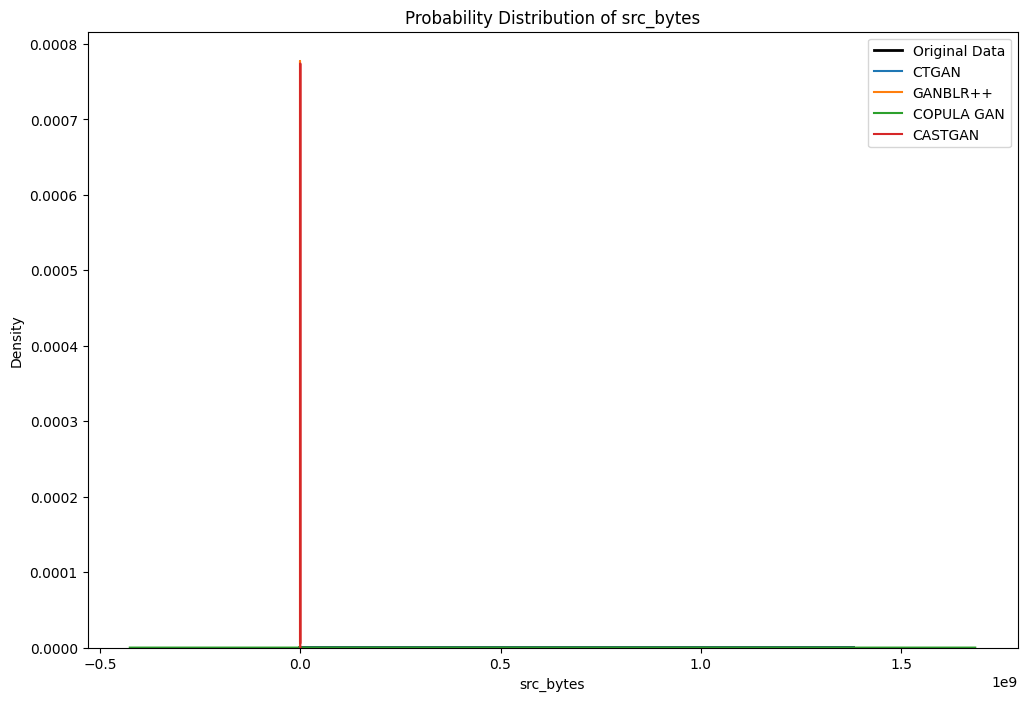

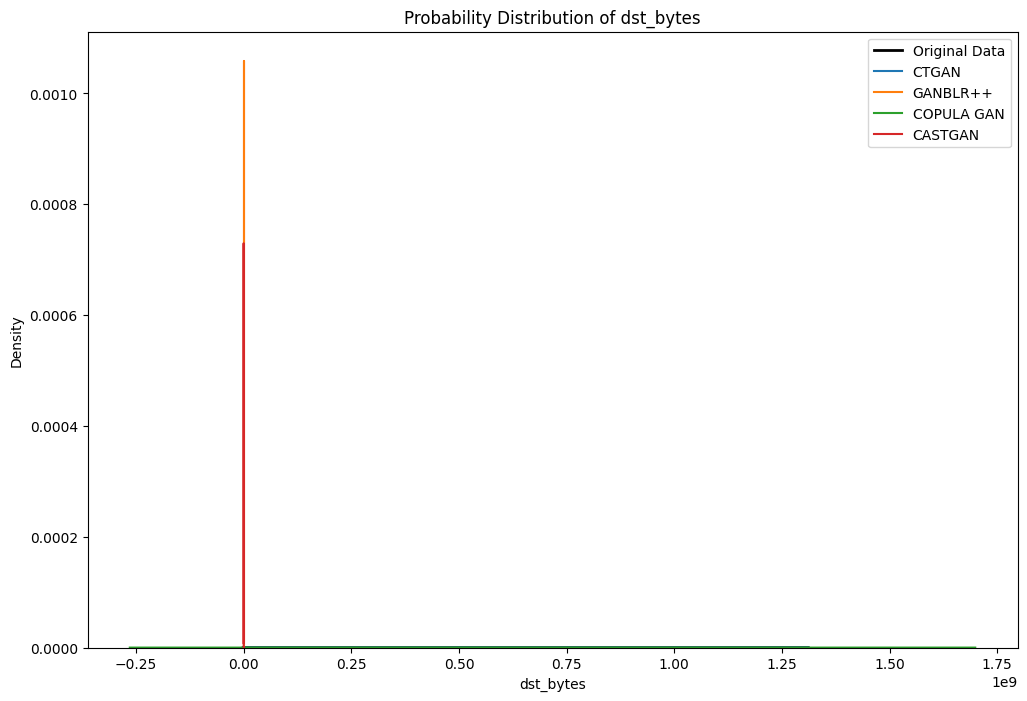

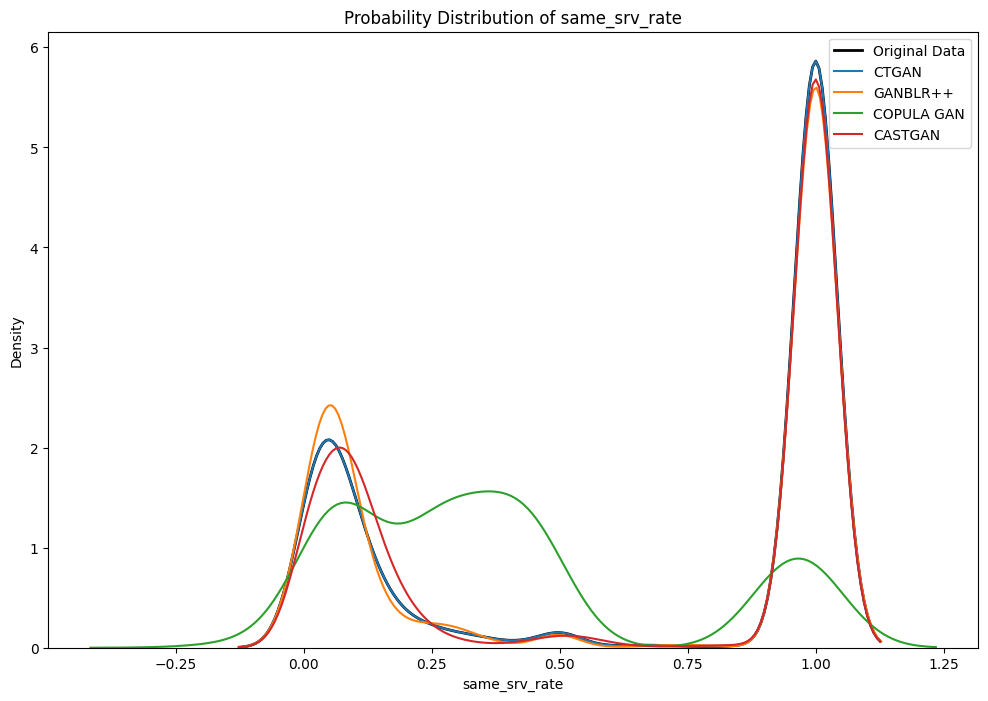

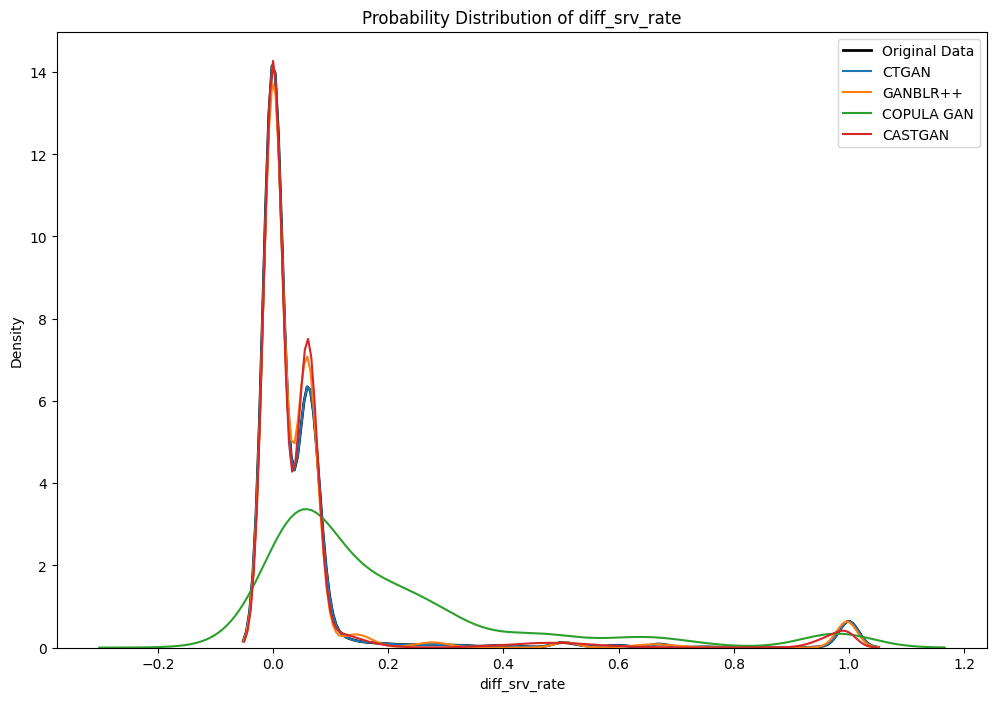

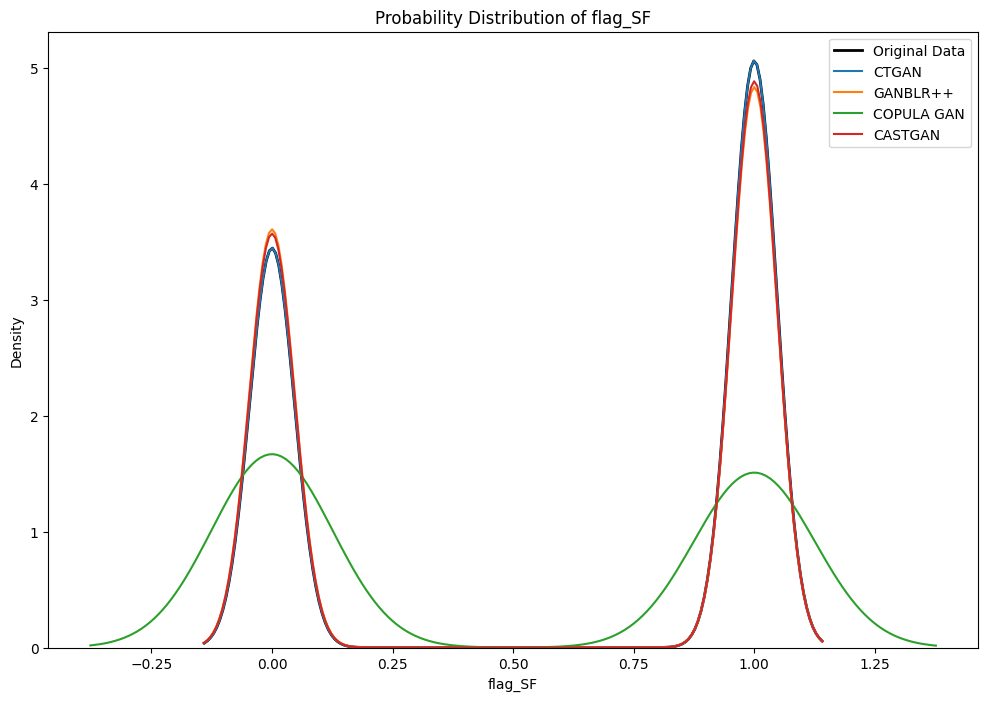

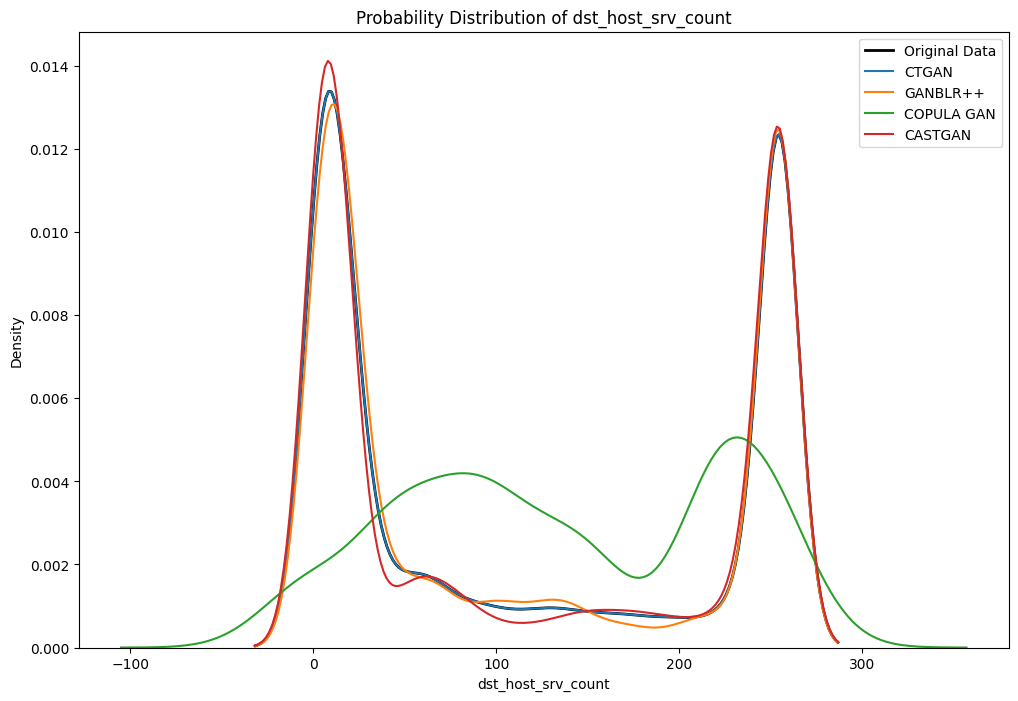

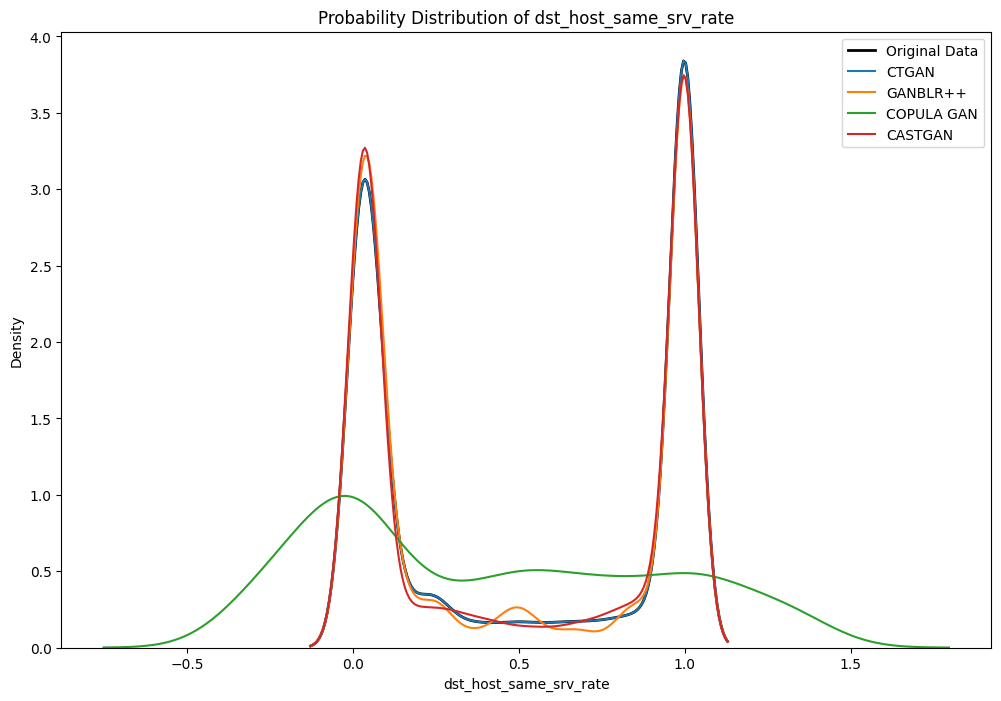

C:\Users\USTB\AppData\Local\Temp\ipykernel_10900\2701968523.py:89: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(synthetic_data[column], label=title)


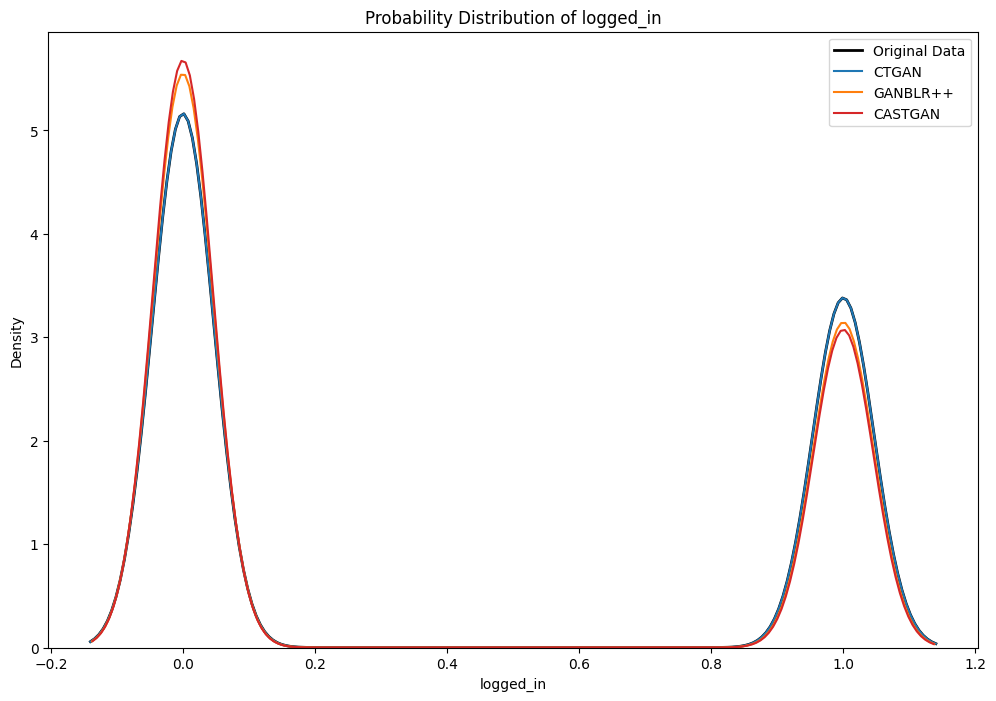

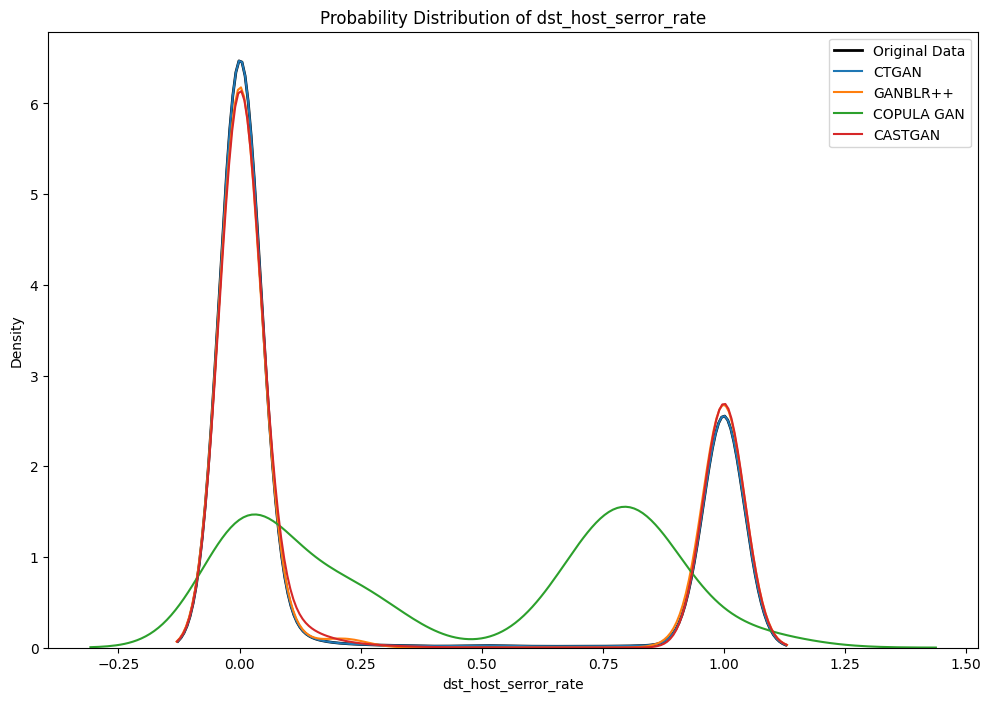

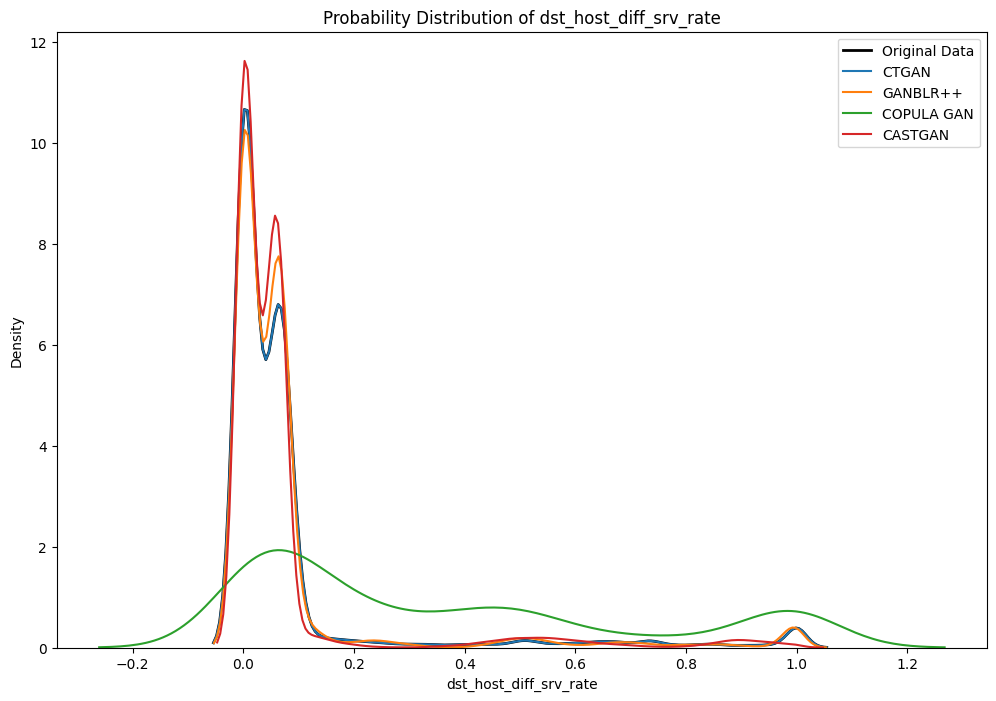

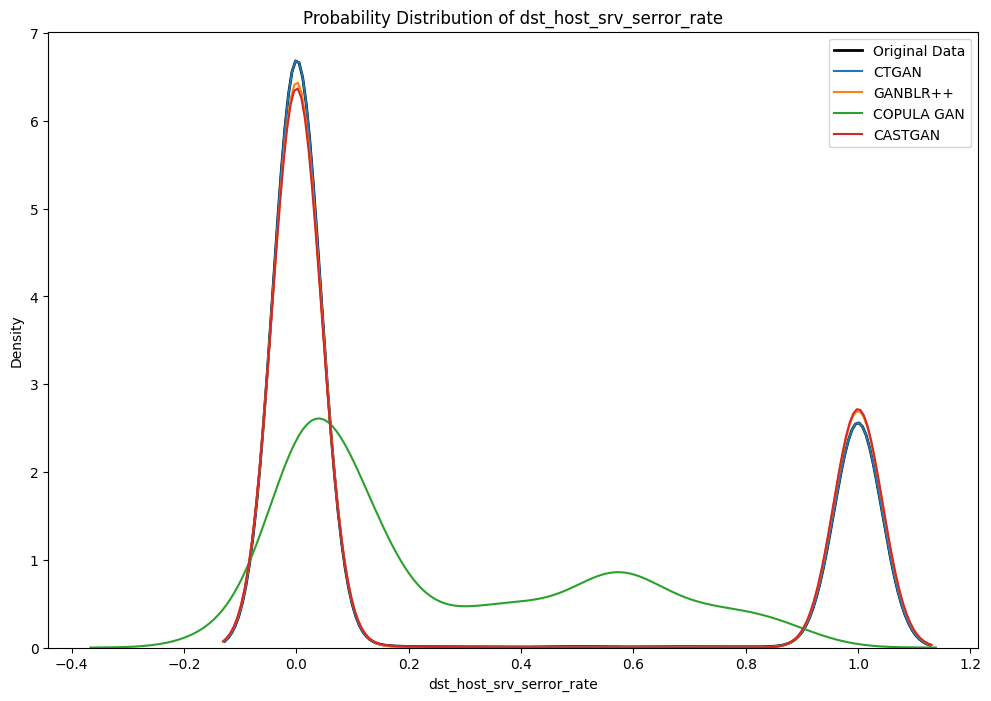

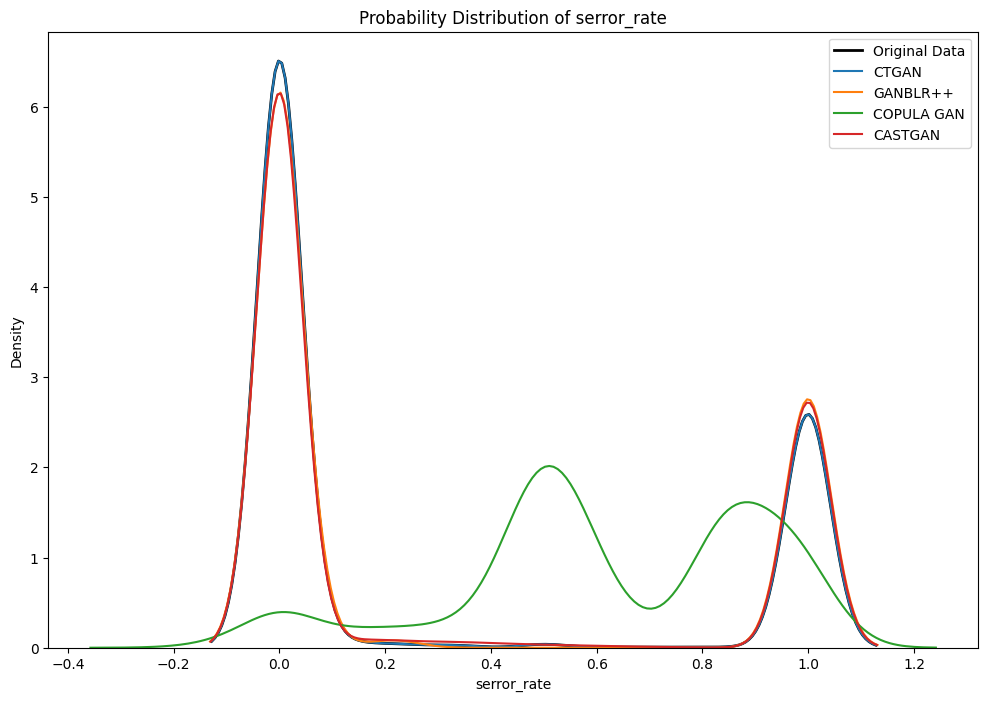

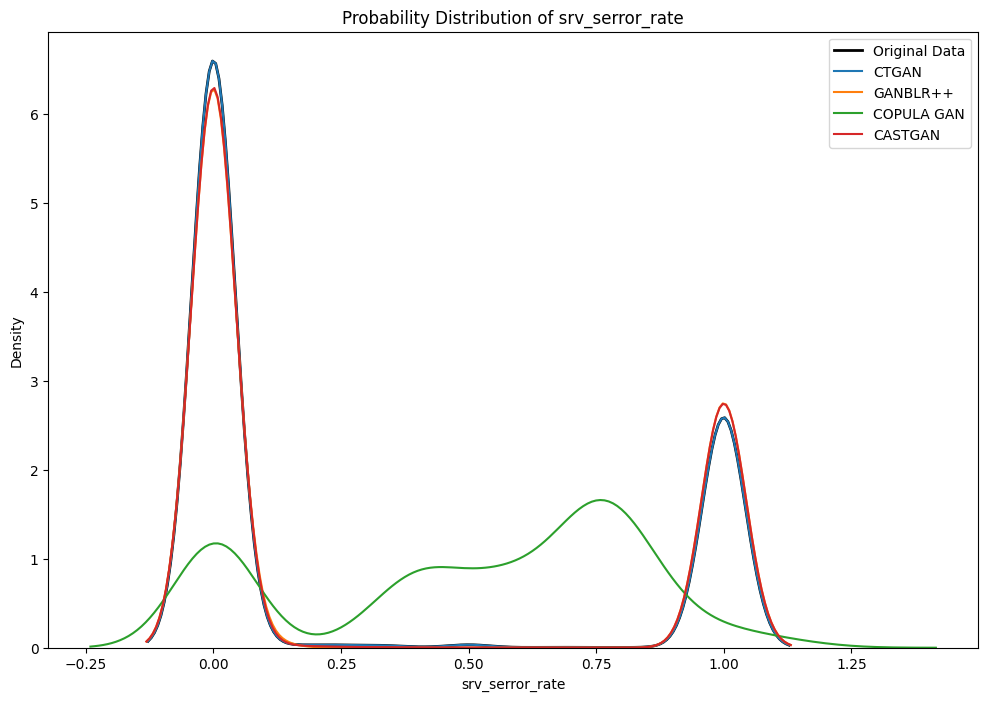

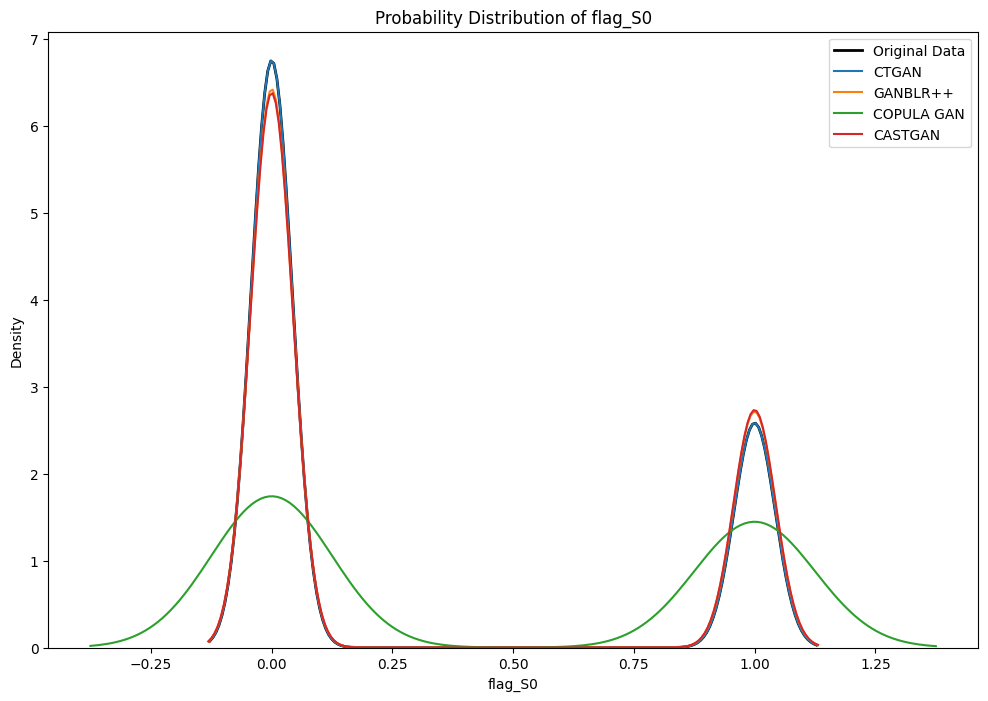

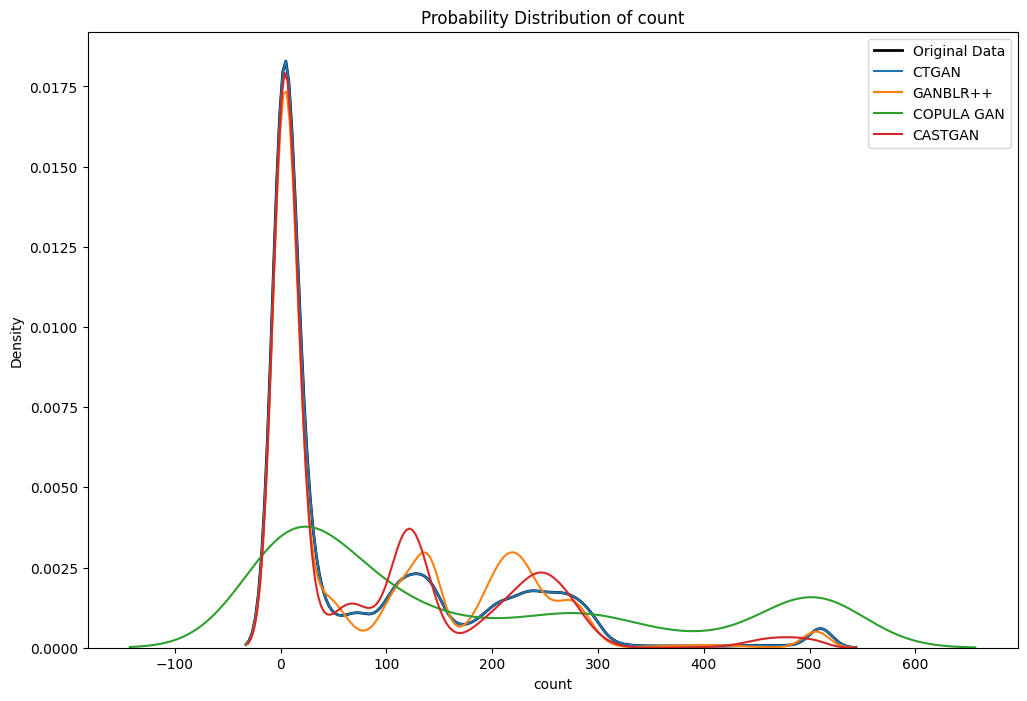

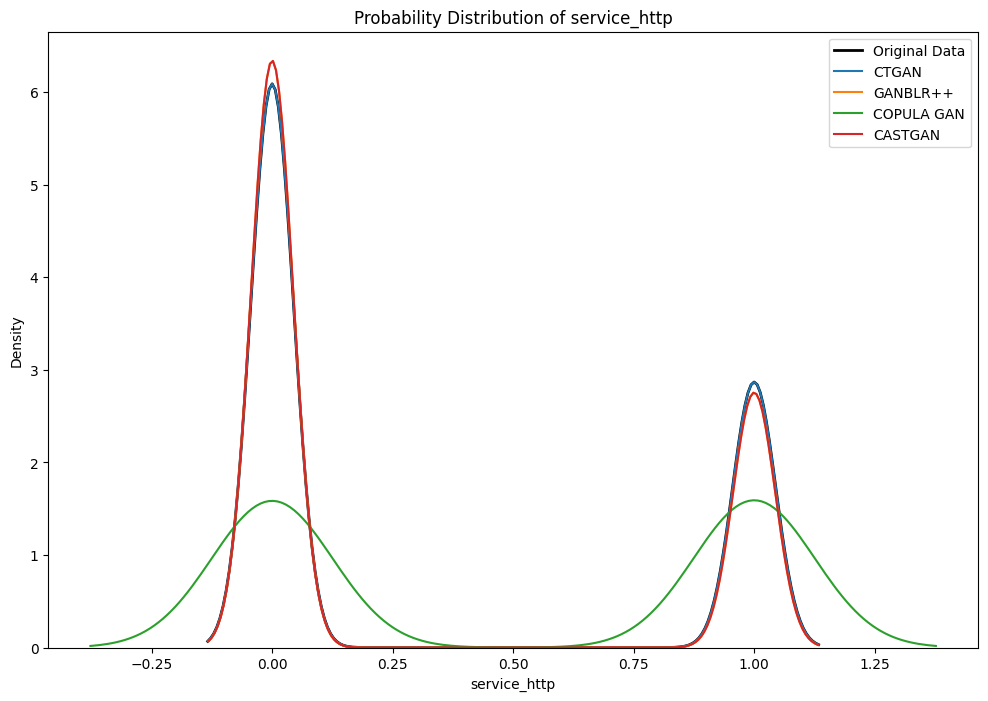

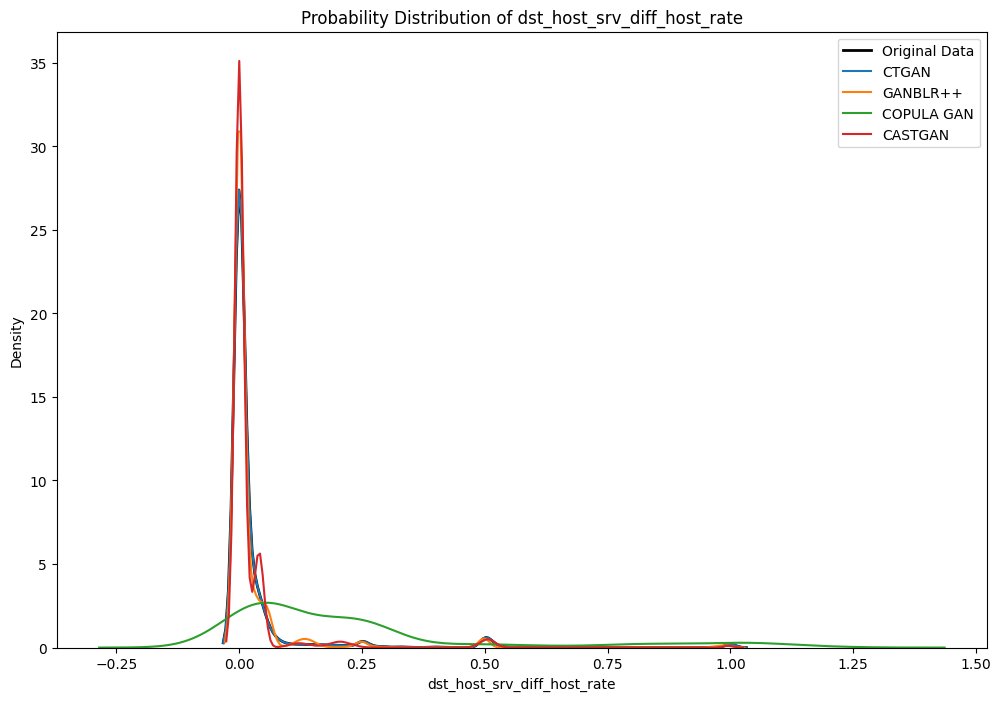

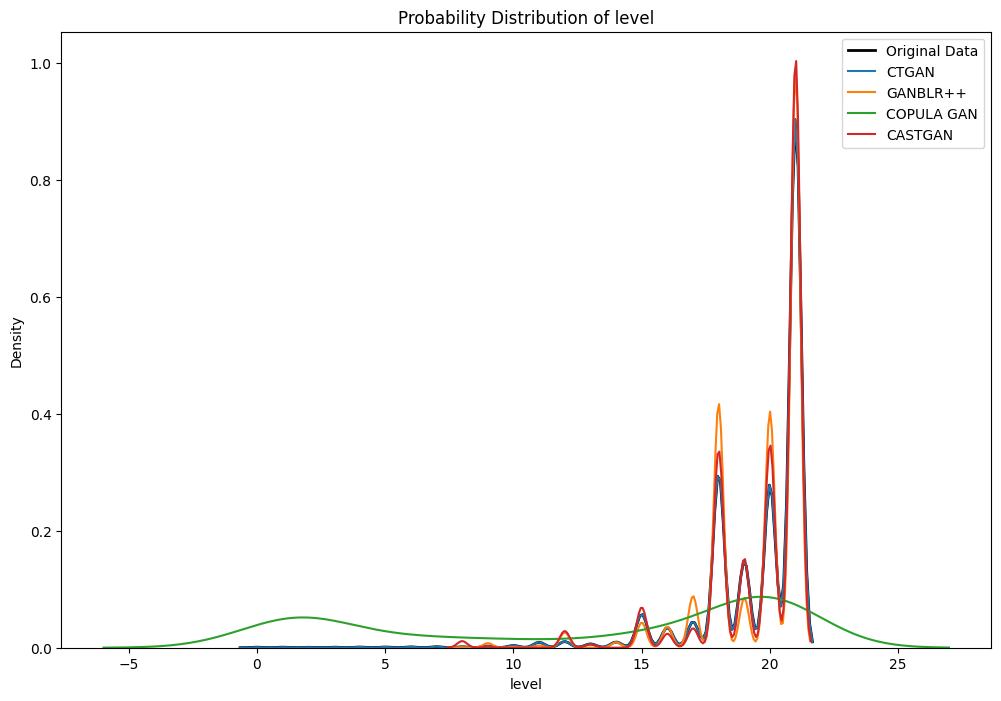

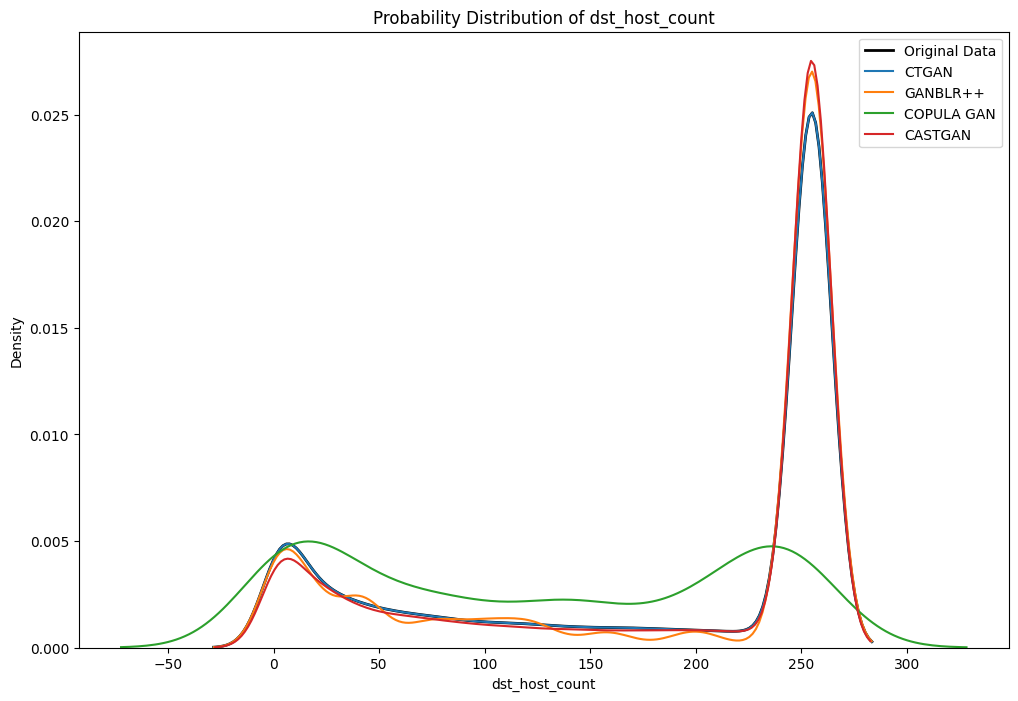

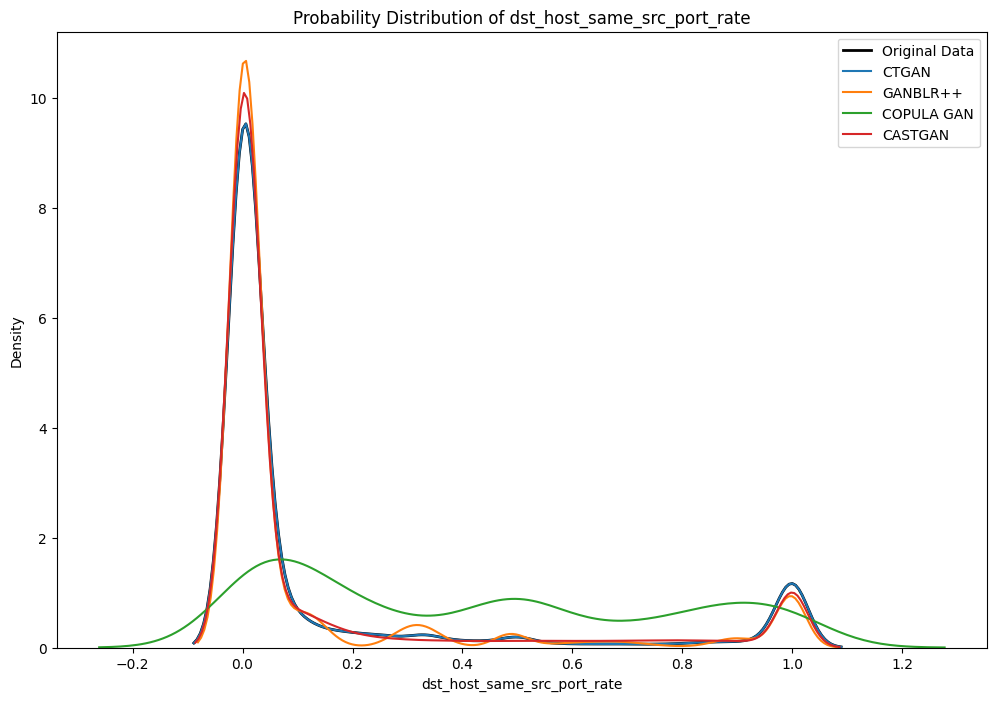

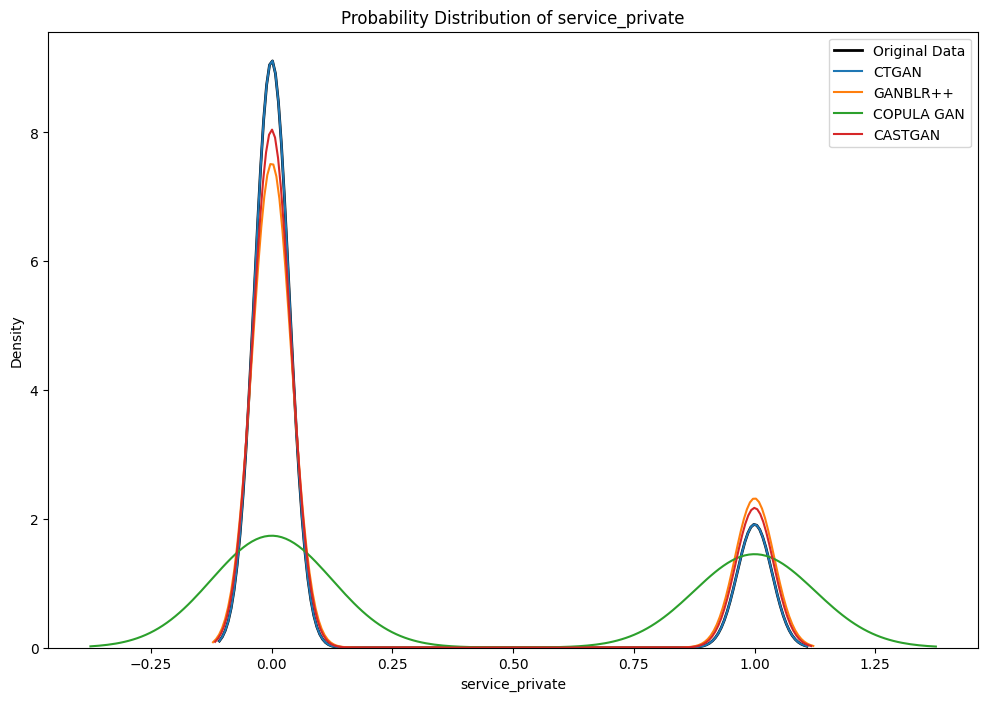

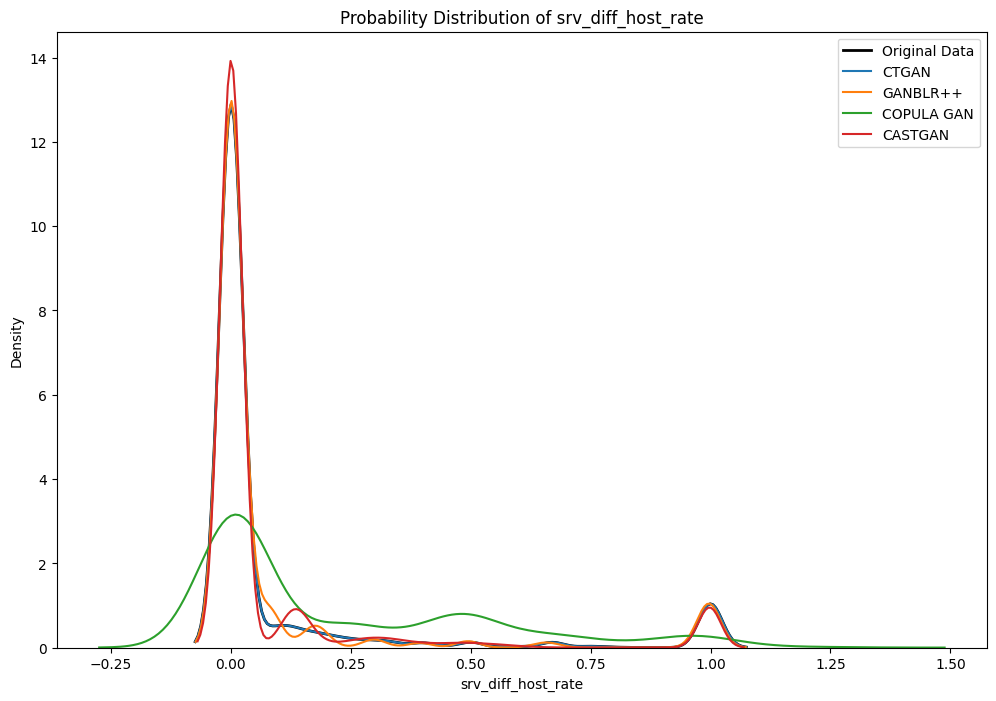

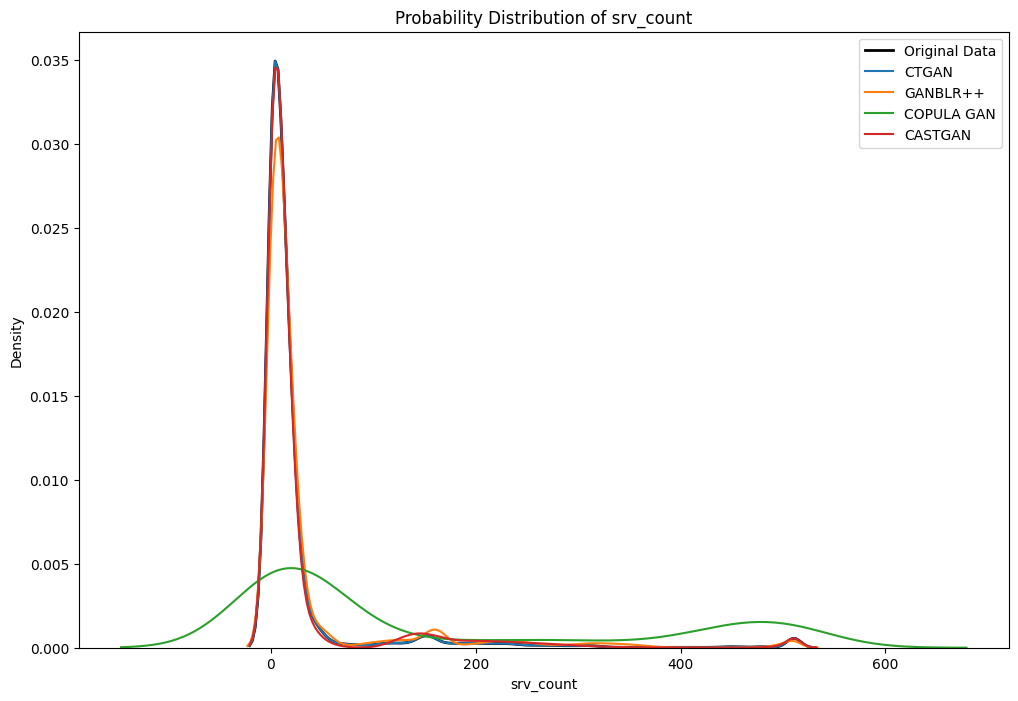

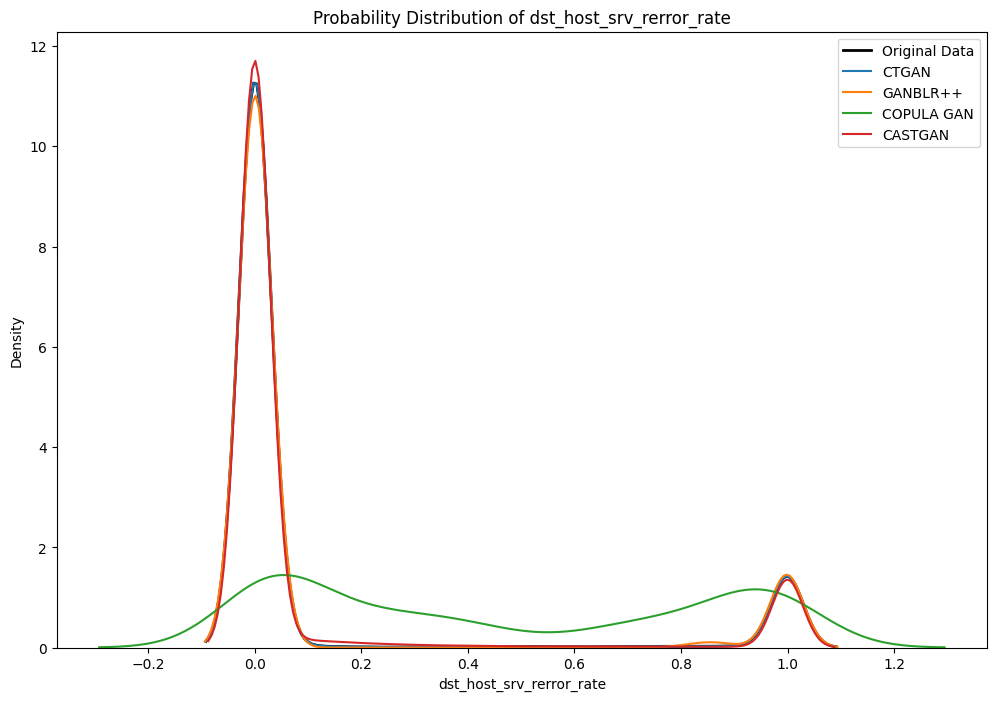

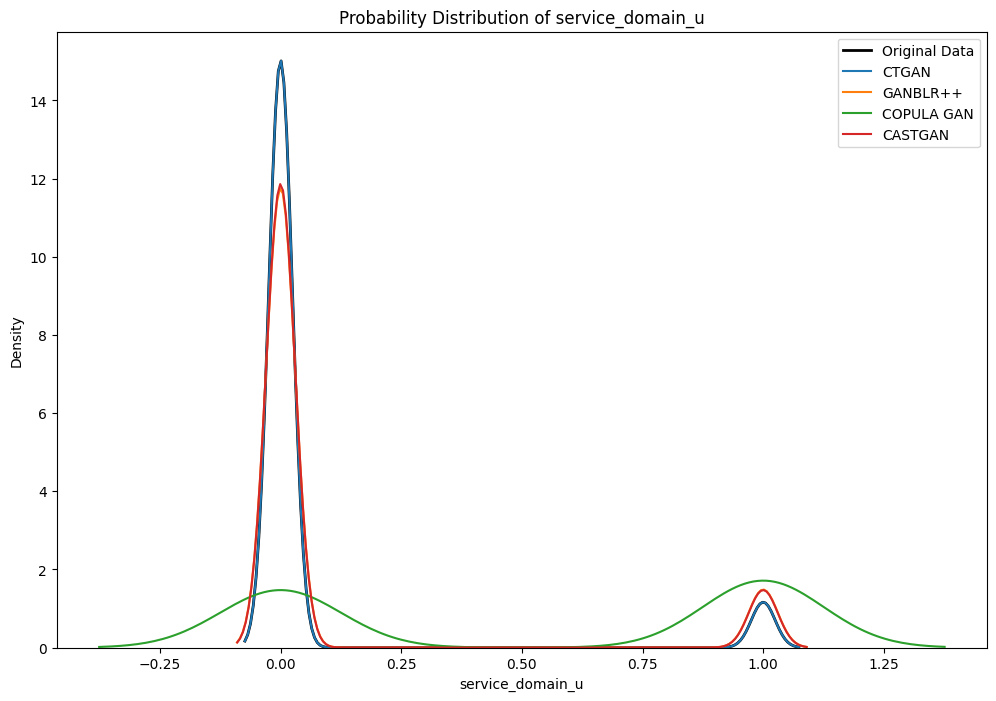

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# List of DataFrames and their titles
dfs = [df, data_ctgan, data_ganblrpp, data_copula_gan, data_castgan]
titles = ["Original Data", "CTGAN", "GANBLR++", "COPULA GAN", "CASTGAN"]

# Function to compare distributions and calculate KS test results
def compare_distributions(real_data, synthetic_datasets, titles):
    results = {}
    average_results = {}
    
    for synthetic_data, title in zip(synthetic_datasets, titles):
        
        ks_results = []
        
        equal_count = 0
        different_count = 0
        
        for column in real_data.columns:
            if column == 'target':
                continue
            
            if column not in synthetic_data.columns:
                print(f"Column {column} not found in dataset {title}. Skipping.")
                continue
            
            real_values = real_data[column].values
            synthetic_values = synthetic_data[column].values
            
            # Perform KS Test
            ks_statistic, ks_p_value = ks_2samp(real_values, synthetic_values)
            
            # Store KS test results
            ks_results.append({
                'Feature': column,
                'KS Statistic': ks_statistic,
                'KS P-value': ks_p_value
            })
            
            # Count equal and different distributions
            if ks_p_value > 0.05:
                equal_count += 1
            else:
                different_count += 1
        
        # Store results for current synthetic dataset
        results[title] = ks_results
        
        # Calculate average results
        total_features = len(real_data.columns) - 1  # excluding target column
        average_results[title] = {
            'Equal Distributions': equal_count,
            'Different Distributions': different_count,
            'Average KS P-value': np.mean([result['KS P-value'] for result in ks_results])
        }
    
    # Print average results
    print("\n--- Average Results ---")
    for title, avg_res in average_results.items():
        print(f"{title}:")
        print(f"Equal Distributions: {avg_res['Equal Distributions']}")
        print(f"Different Distributions: {avg_res['Different Distributions']}")
        print(f"Average KS P-value: {avg_res['Average KS P-value']}")
        print("-----------------------------")
    
    return results, average_results

# Function to plot KDE plots for all features across all datasets
def plot_kde_comparison(real_data, synthetic_datasets, titles):
    num_datasets = len(synthetic_datasets)  # excluding original data
    num_features = len(real_data.columns) - 1  # excluding target column
    
    for column in real_data.columns:
        if column == 'target':
            continue
        
        plt.figure(figsize=(12, 8))
        
        # Plot the original data curve
        sns.kdeplot(real_data[column], label='Original Data', linewidth=2, color='black')
        
        # Plot KDE for each synthetic dataset
        for i, (synthetic_data, title) in enumerate(zip(synthetic_datasets, titles[1:])):  # Skip the original in titles
            if column in synthetic_data.columns:
                sns.kdeplot(synthetic_data[column], label=title)
        
        plt.title(f'Probability Distribution of {column}')
        plt.legend()
        plt.show()

# Example usage
results, average_results = compare_distributions(df, dfs, titles)
plot_kde_comparison(df, dfs, titles)



--- Average Results ---
Original Data:
Equal Distributions: 25
Different Distributions: 0
Average KS P-value: 1.0
-----------------------------
CTGAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 3.892642134609082e-18
-----------------------------
GANBLR++:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 2.7424431783230867e-14
-----------------------------
COPULA GAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 4.123941951749359e-11
-----------------------------
CASTGAN:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 0.0019239474804304685
-----------------------------


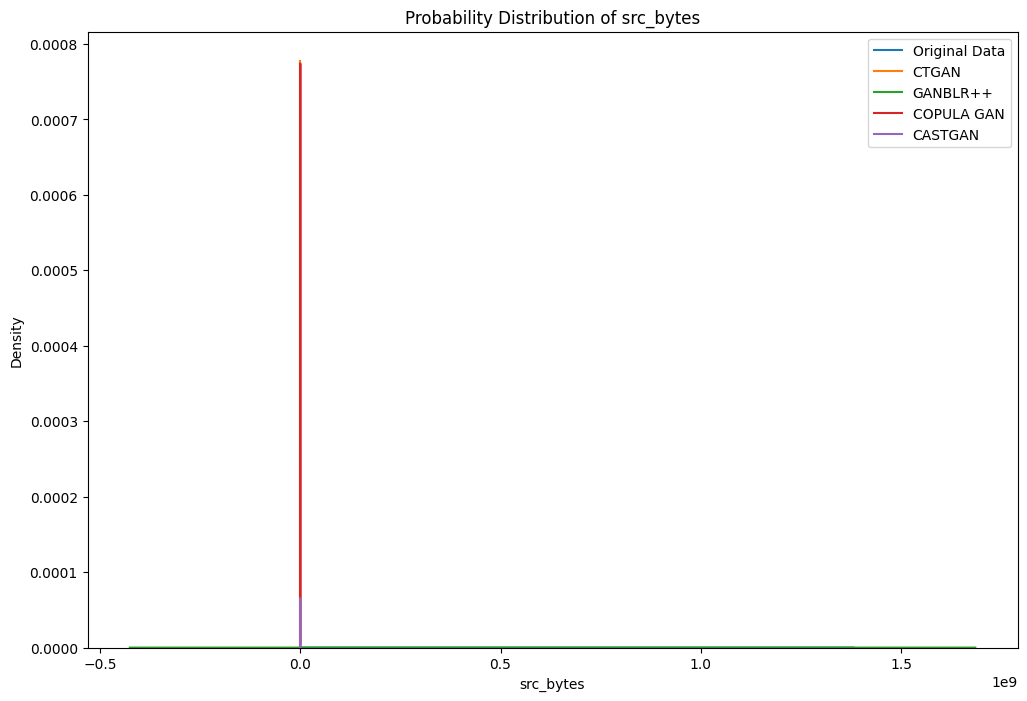

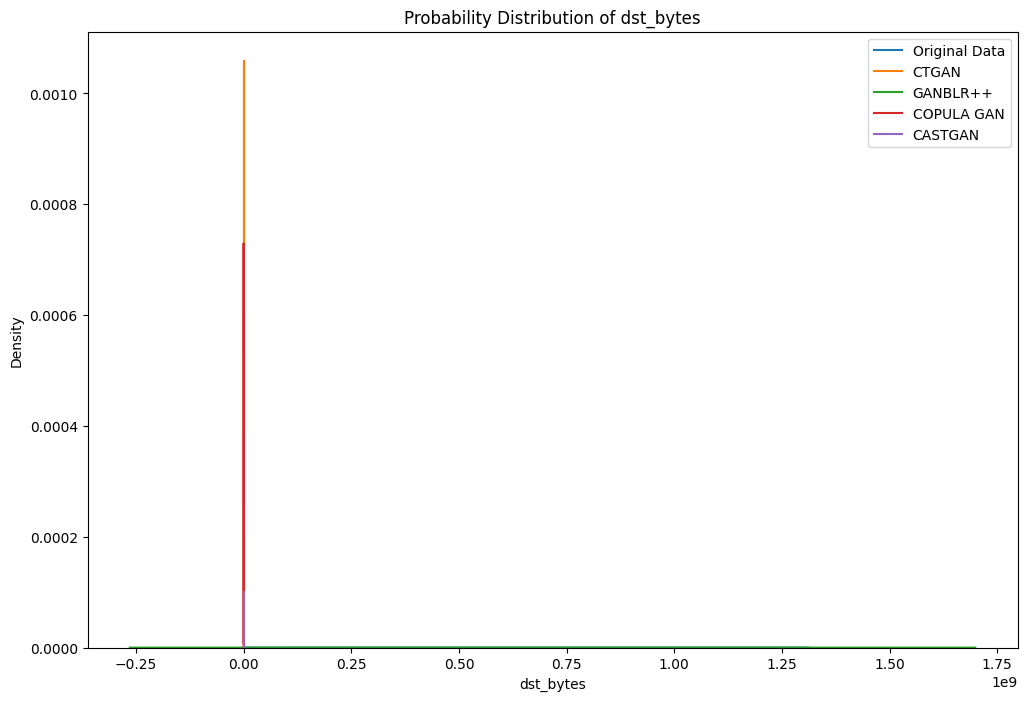

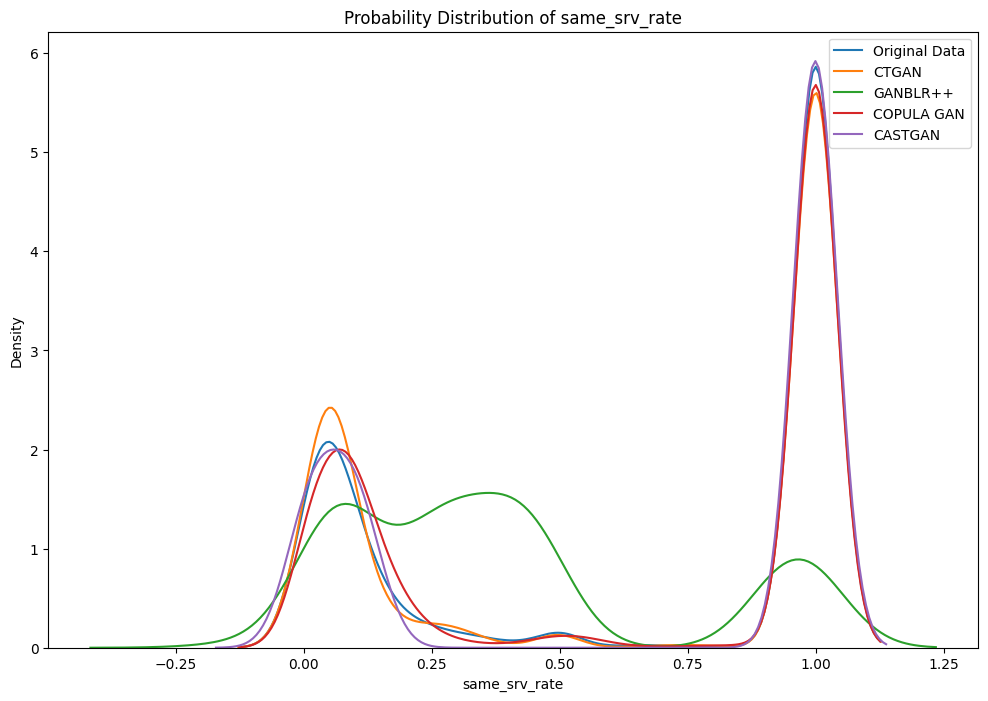

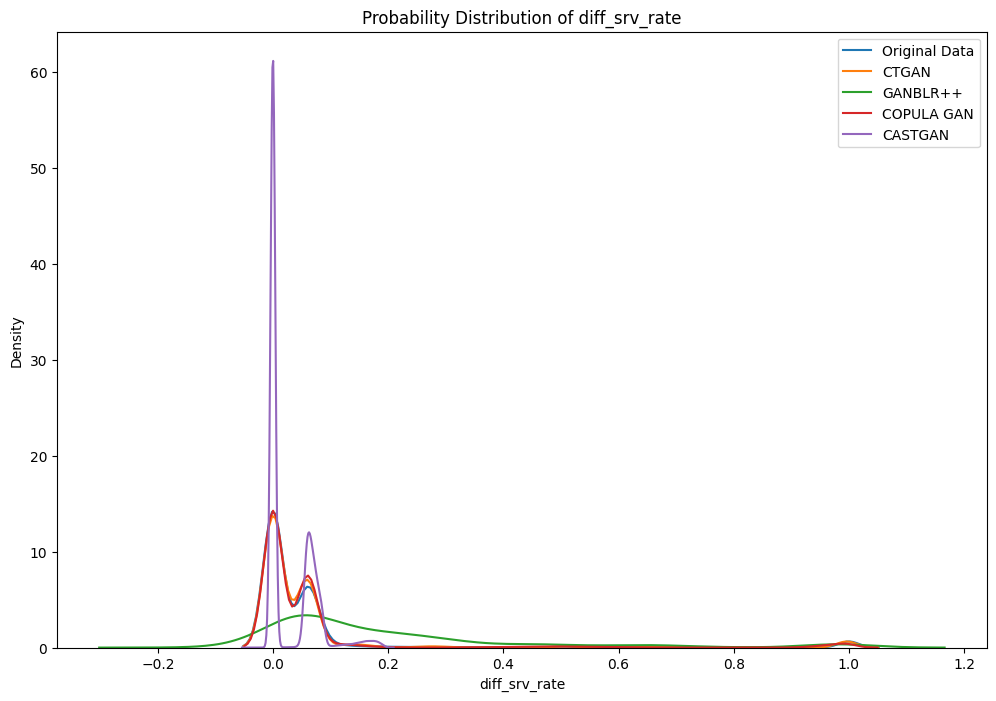

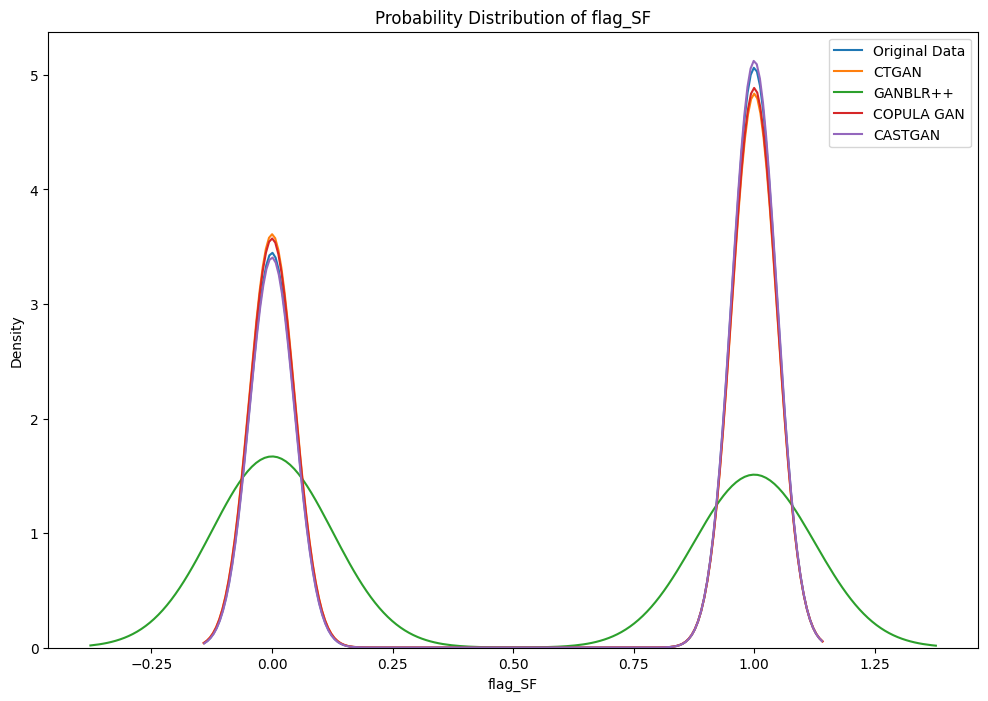

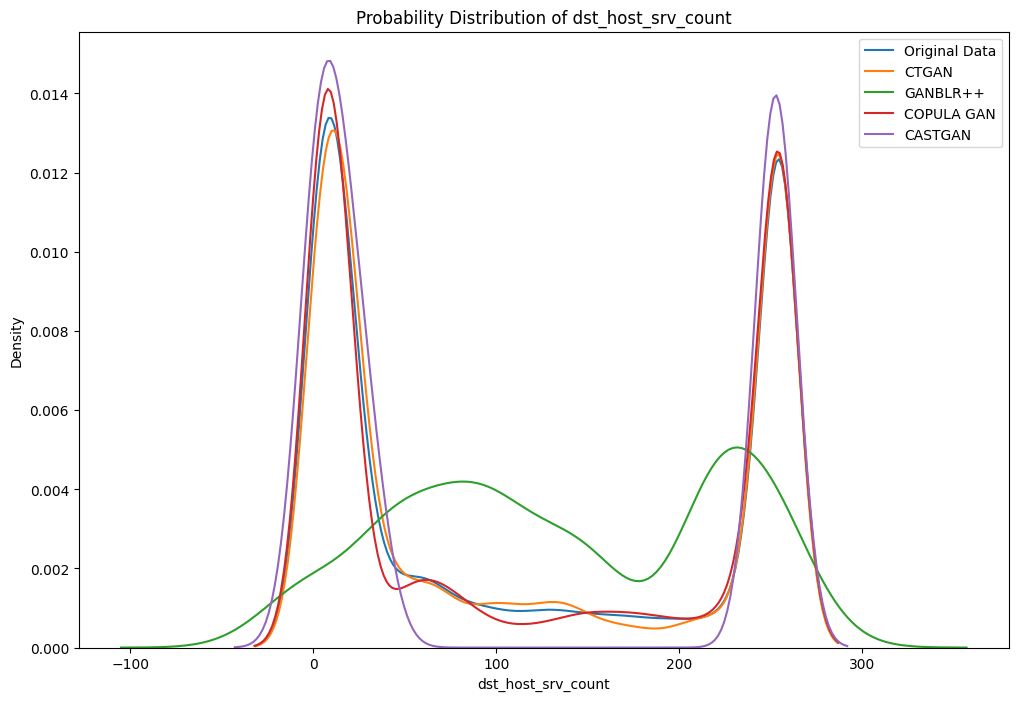

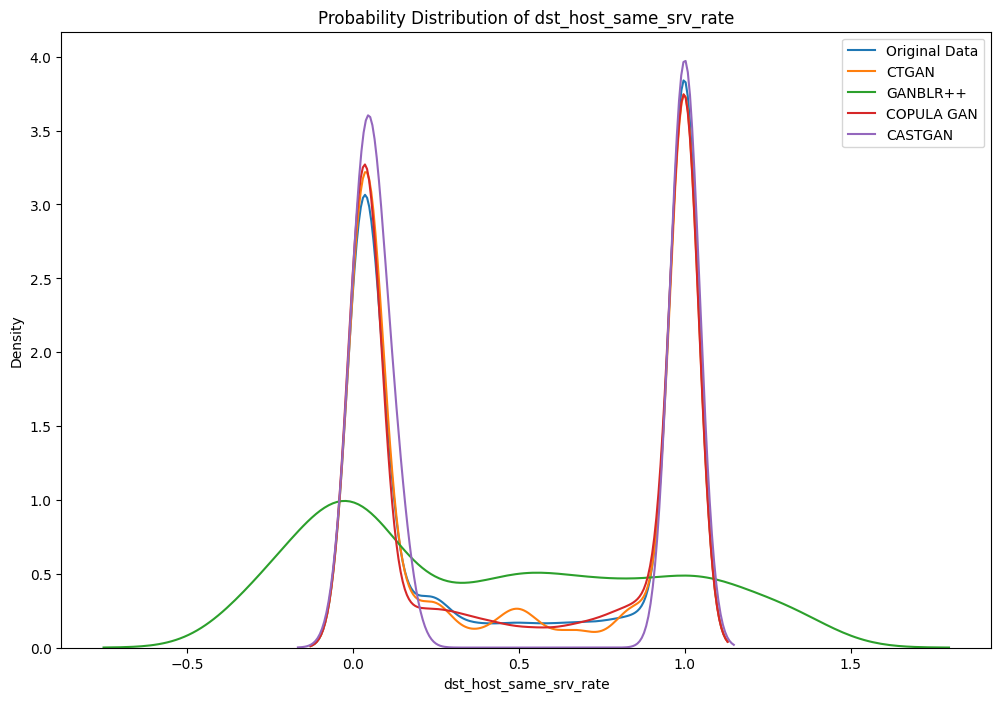

C:\Users\USTB\AppData\Local\Temp\ipykernel_10900\3540036765.py:73: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(synthetic_data[column], label=titles[i])


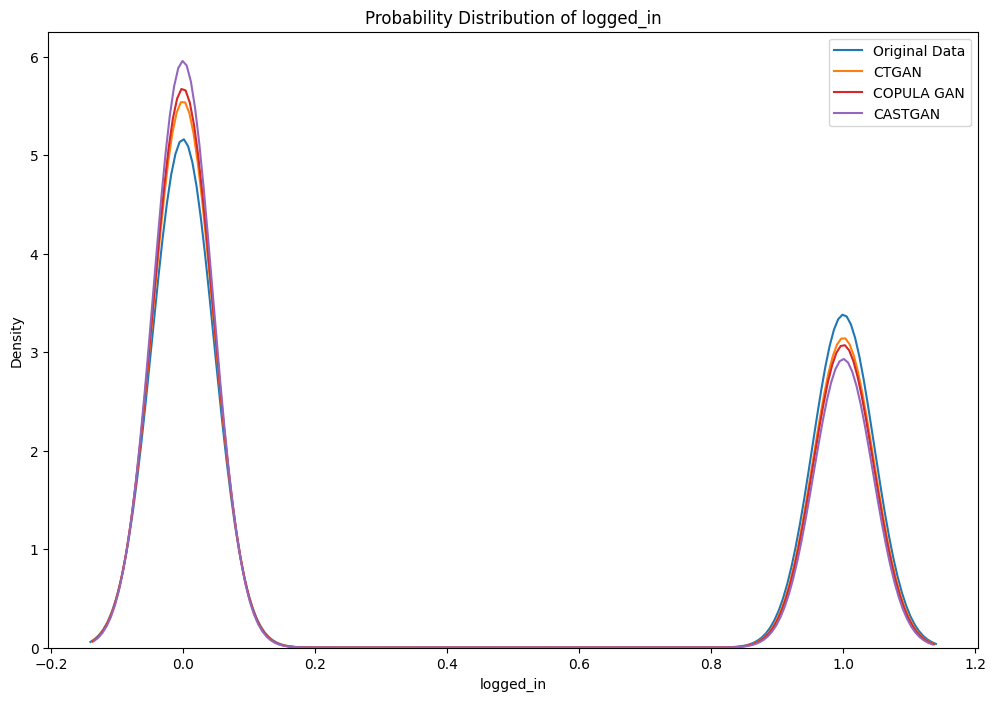

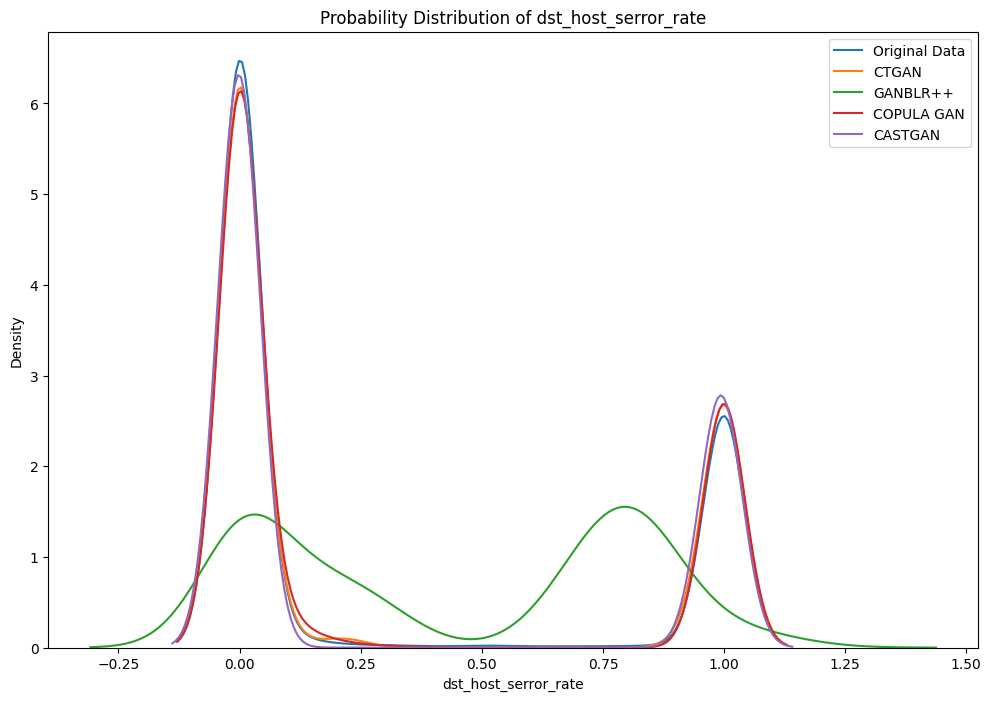

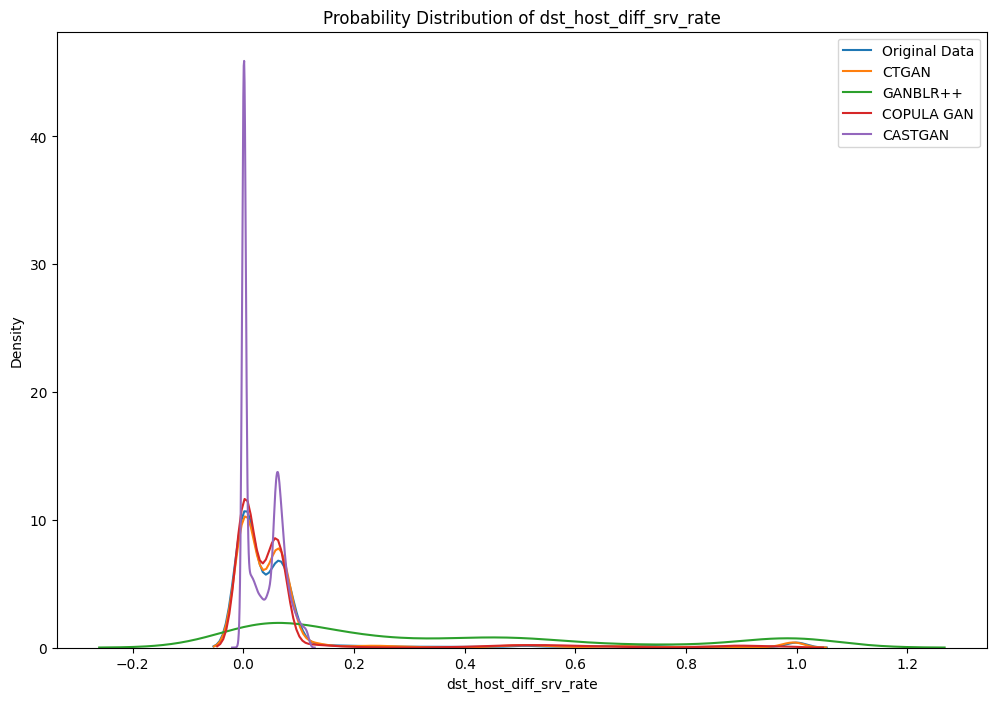

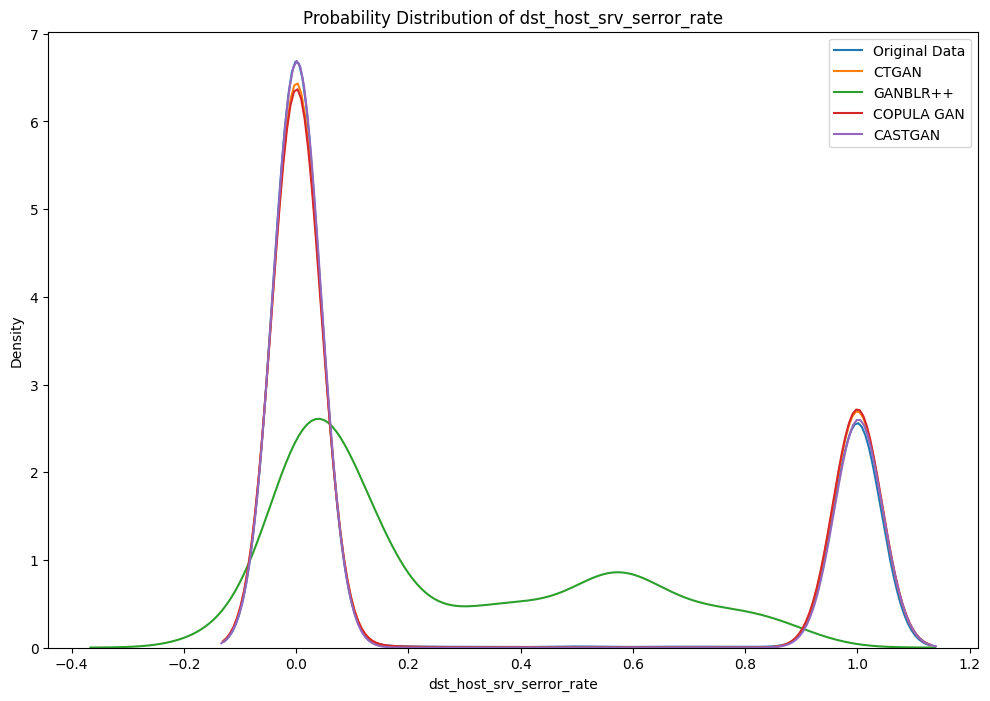

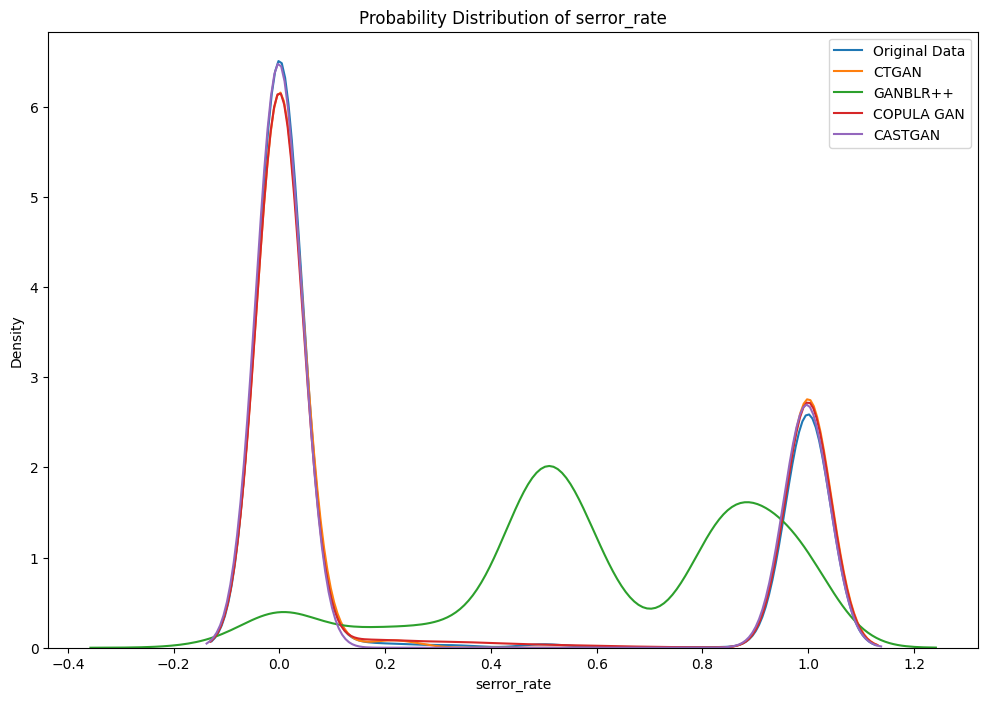

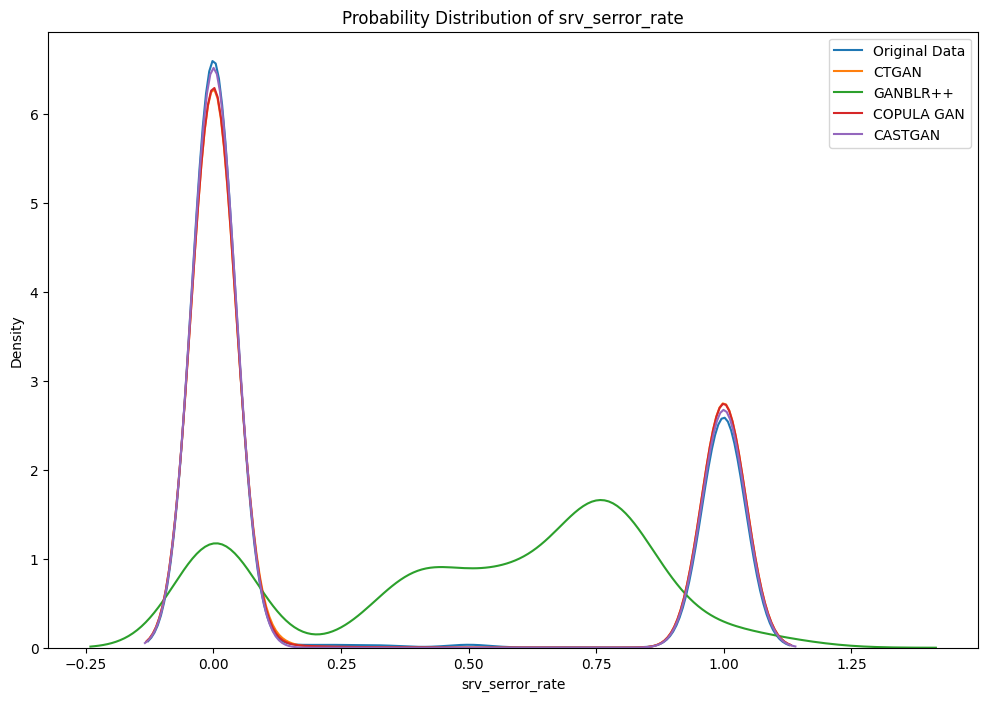

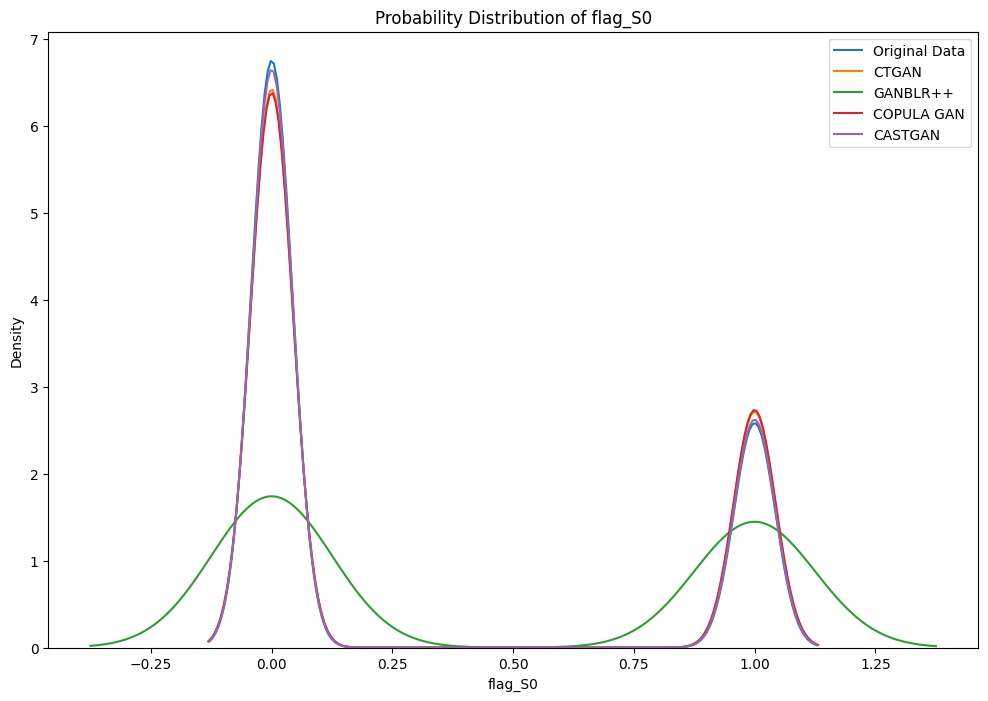

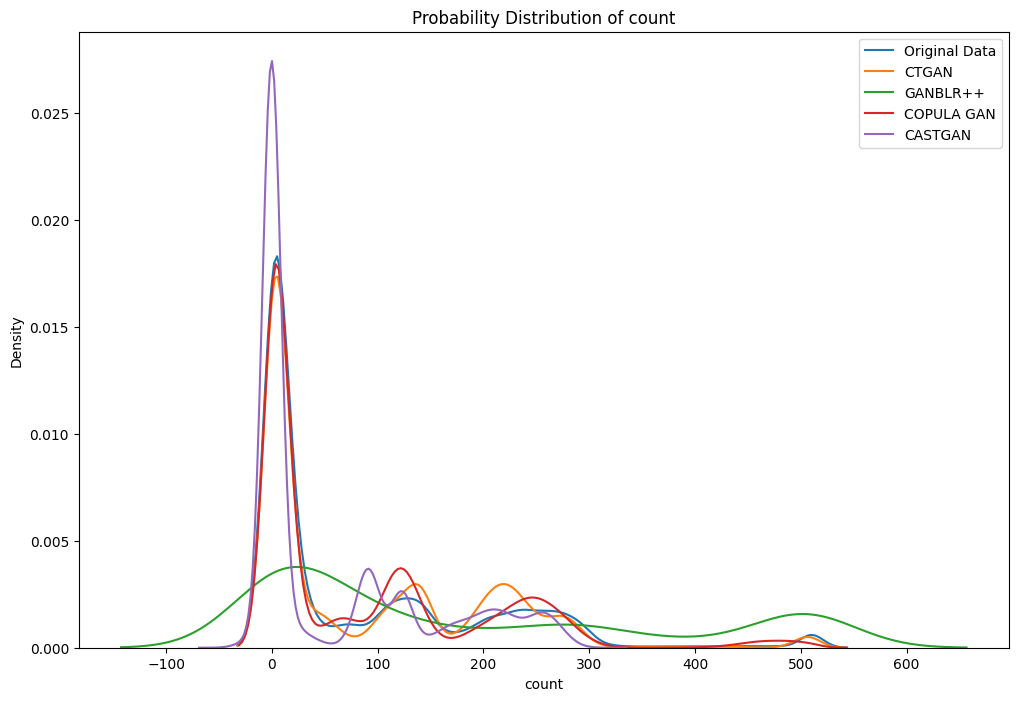

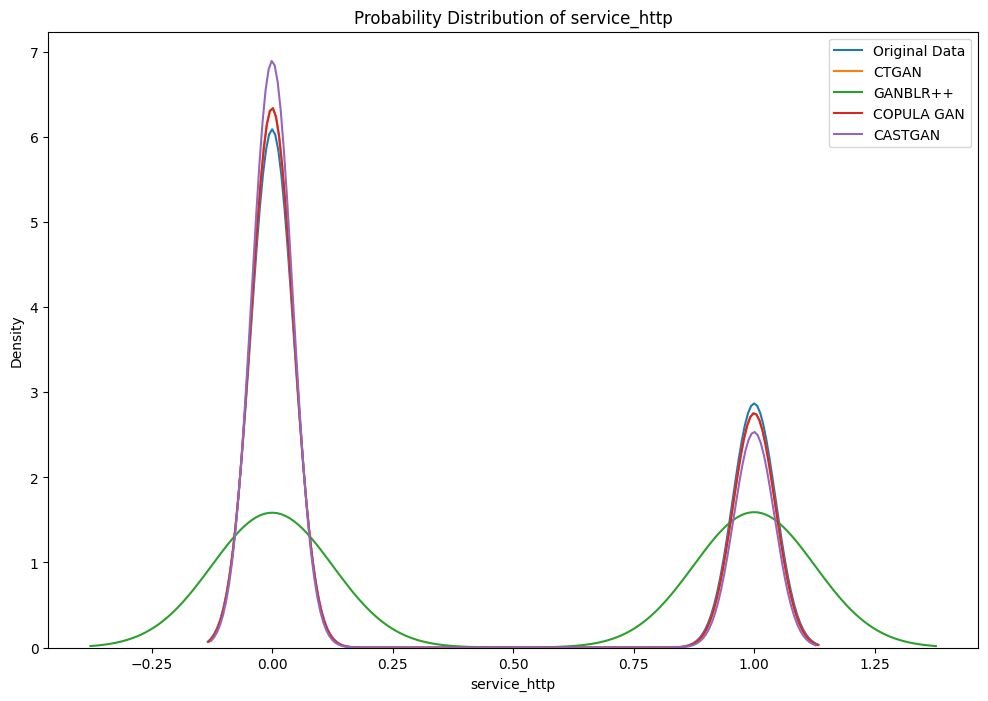

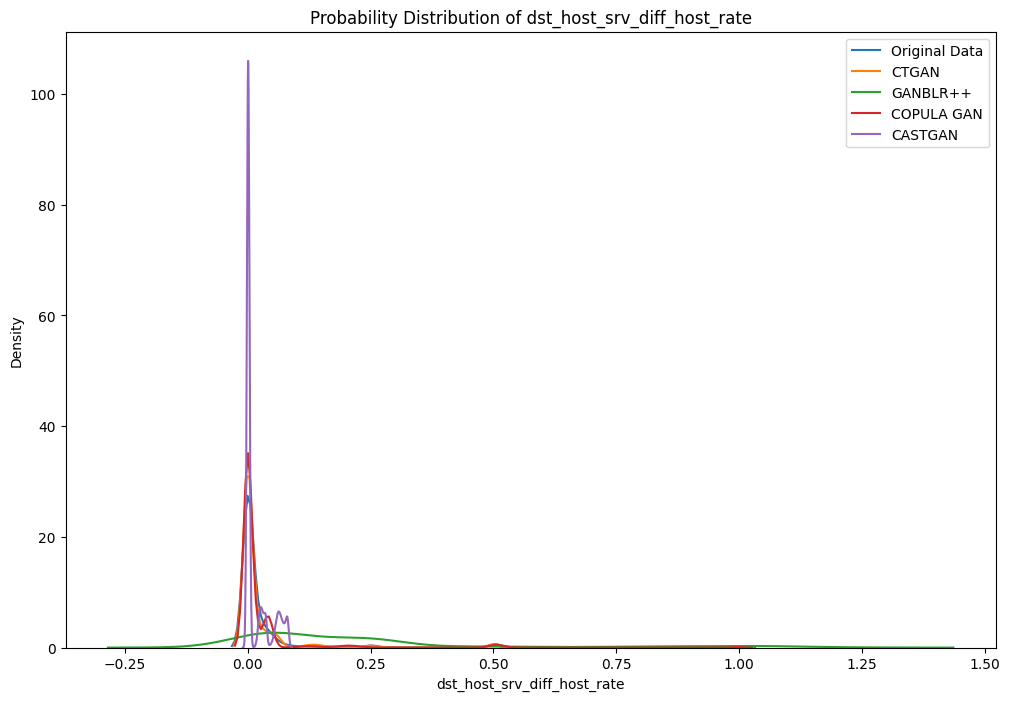

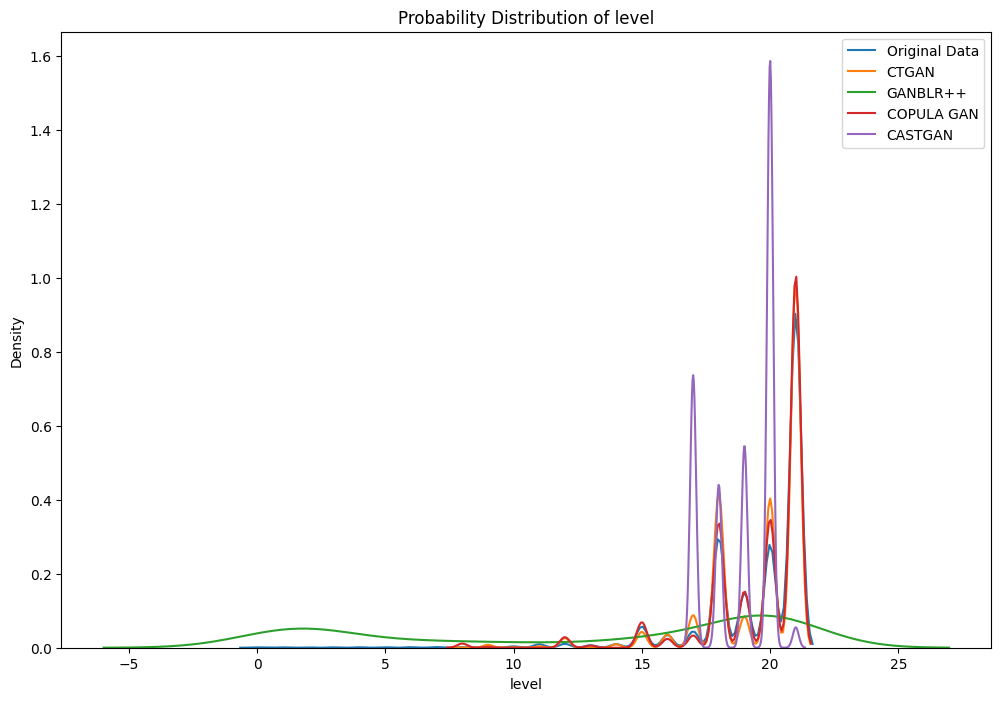

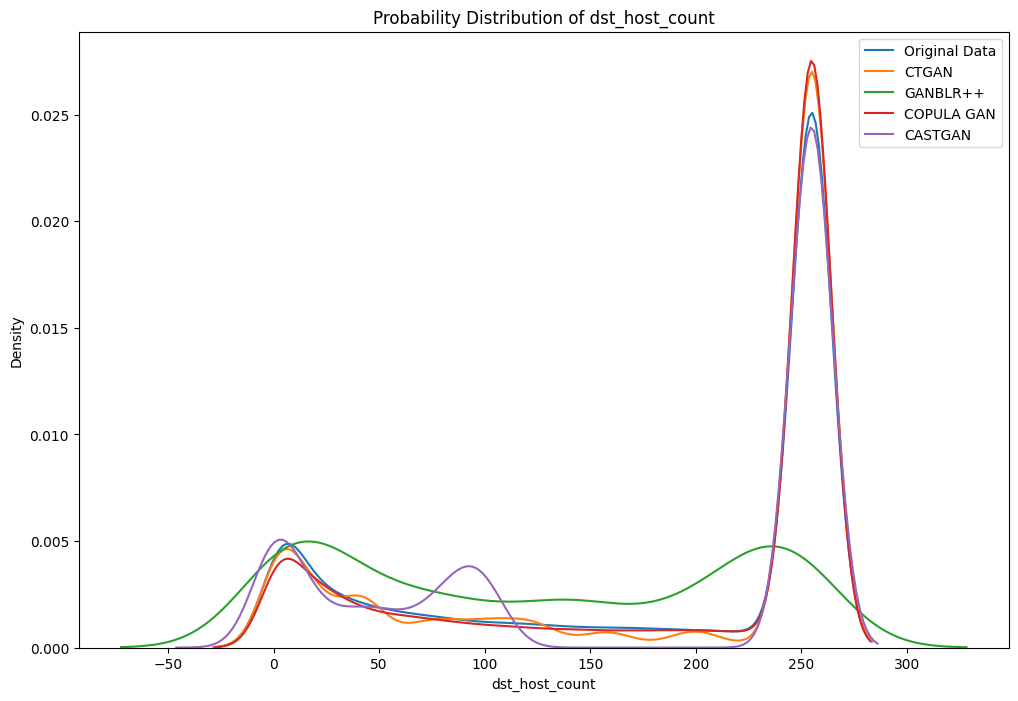

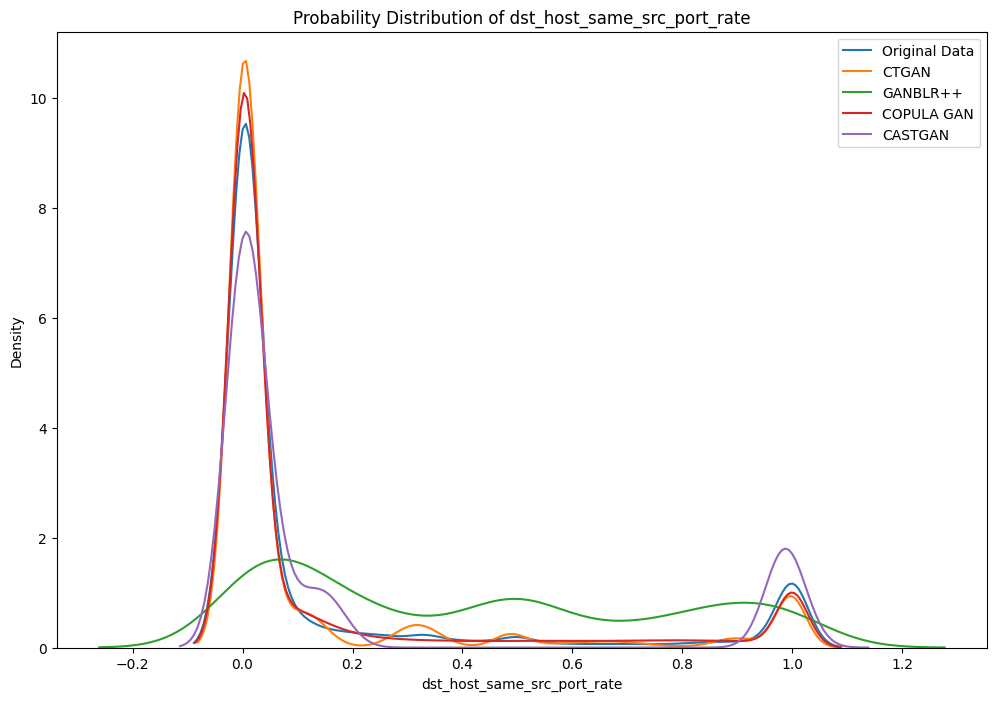

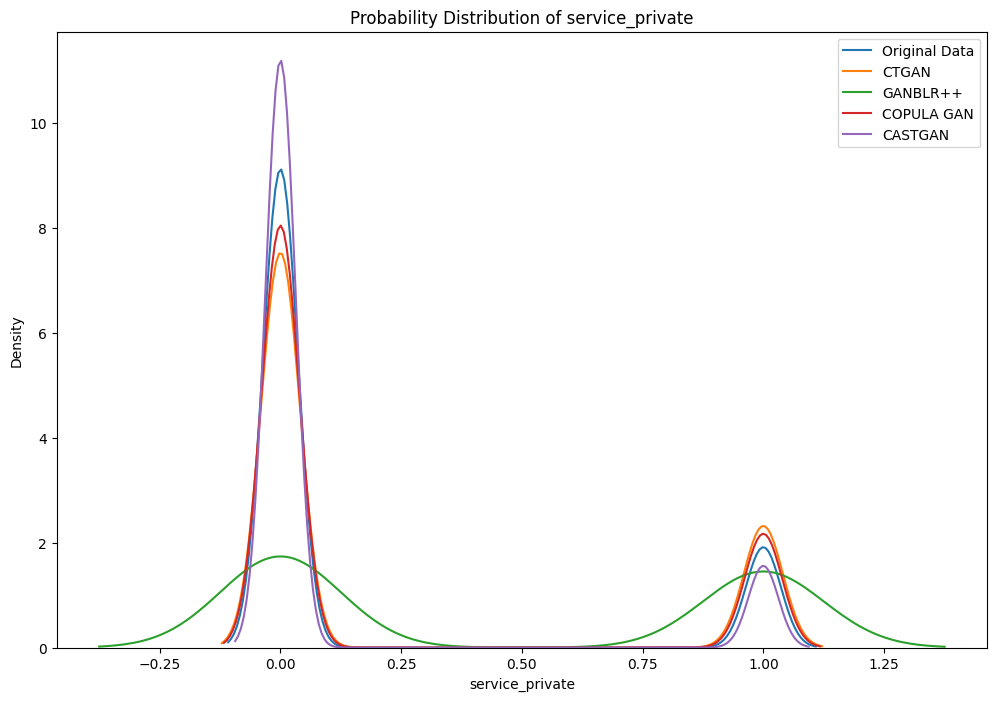

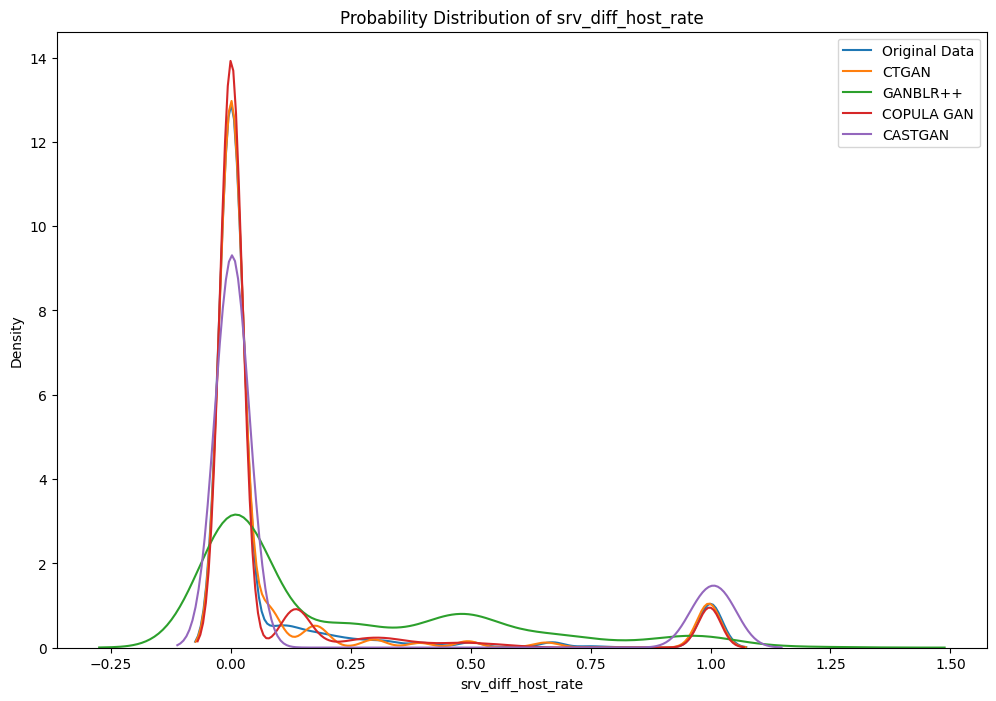

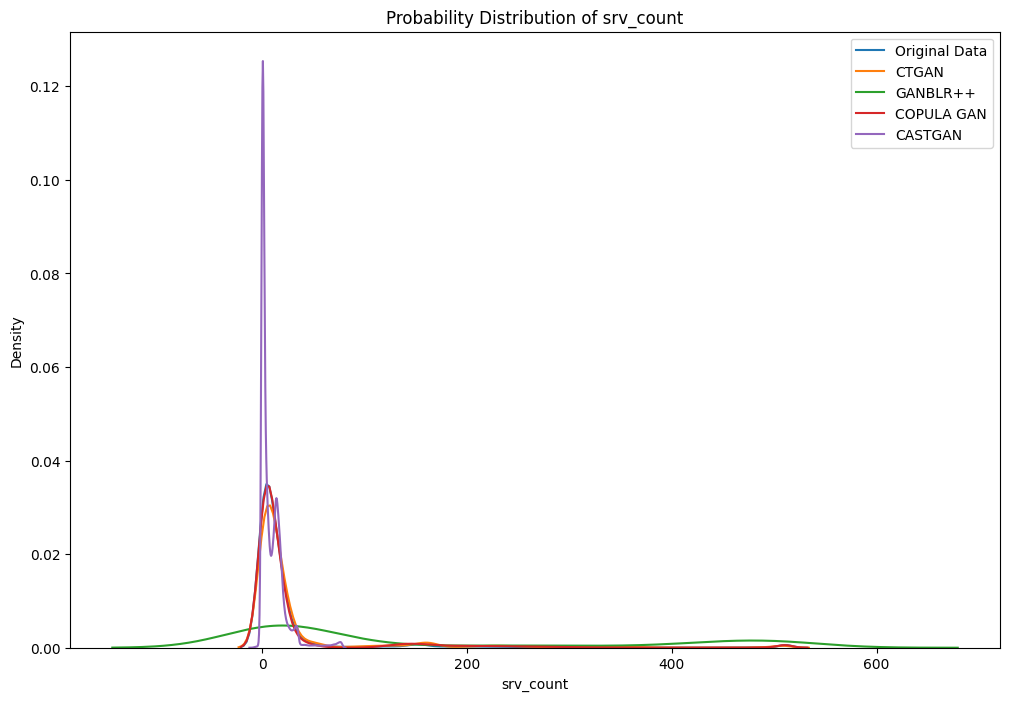

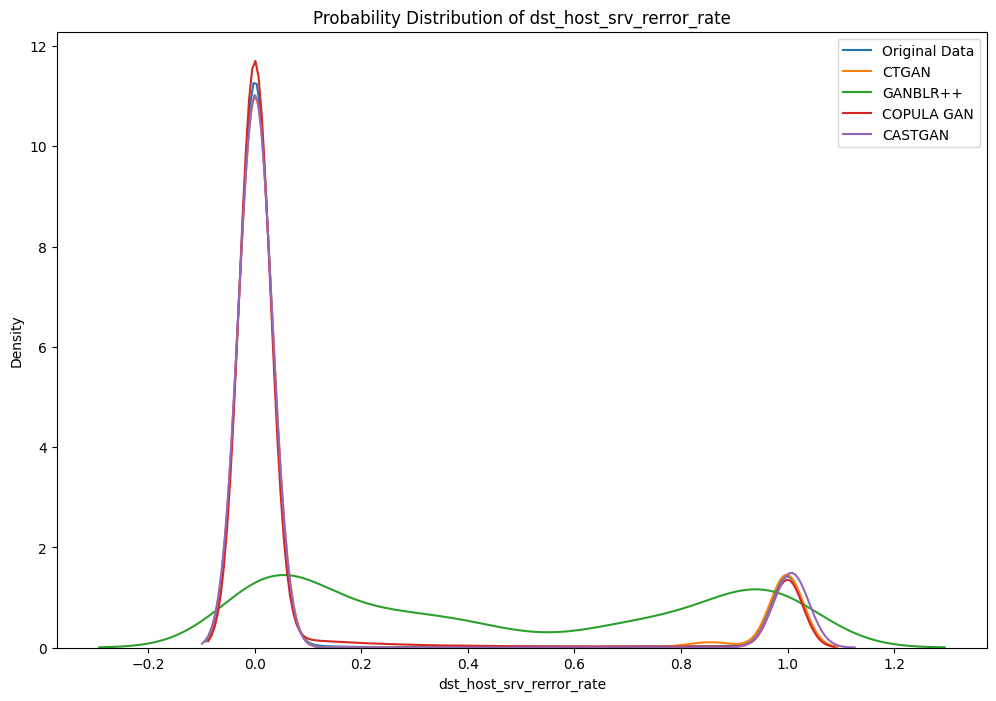

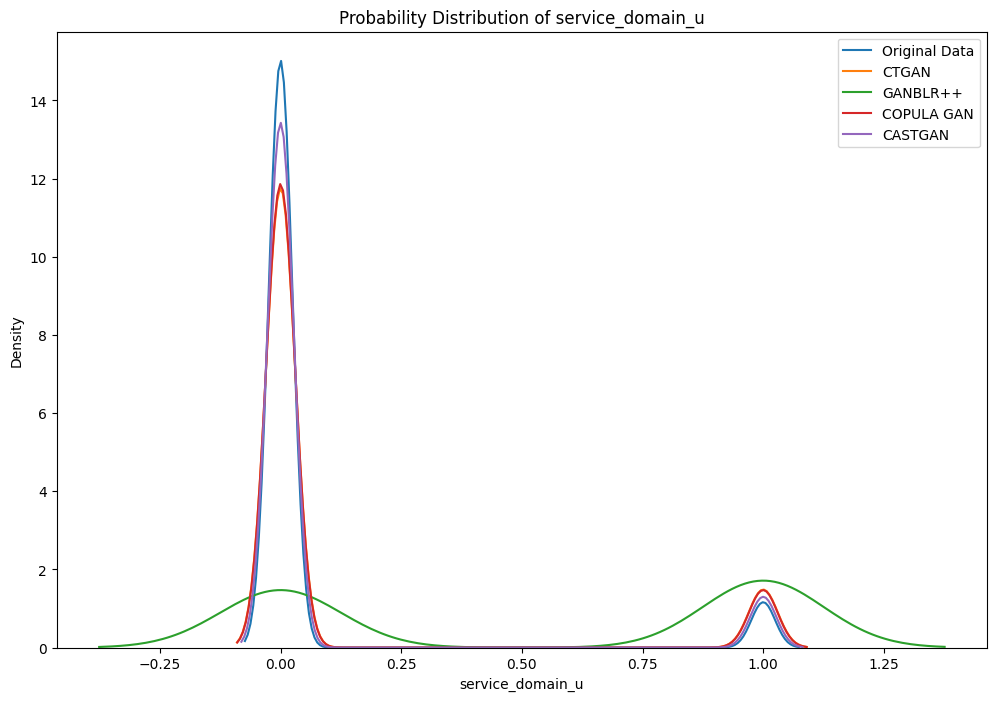

In [19]:

# List of DataFrames
dfs = [df, data_ctgan, data_ganblrpp, data_copula_gan, data_castgan]
titles = ["Original Data", "CTGAN", "GANBLR++", "COPULA GAN", "CASTGAN"]

# Function to compare distributions and calculate KS test results
def compare_distributions(real_data, synthetic_datasets, titles):
    results = {}
    average_results = {}
    
    for synthetic_data, title in zip(synthetic_datasets, titles):
        
        ks_results = []
        
        equal_count = 0
        different_count = 0
        
        for column in real_data.columns:
            if column == 'target':
                continue
            
            real_values = real_data[column].values
            synthetic_values = synthetic_data[column].values
            
            # Perform KS Test
            ks_statistic, ks_p_value = ks_2samp(real_values, synthetic_values)
            
            # Store KS test results
            ks_results.append({
                'Feature': column,
                'KS Statistic': ks_statistic,
                'KS P-value': ks_p_value
            })
            
            # Count equal and different distributions
            if ks_p_value > 0.05:
                equal_count += 1
            else:
                different_count += 1
        
        # Store results for current synthetic dataset
        results[title] = ks_results
        
        # Calculate average results
        total_features = len(real_data.columns) - 1  # excluding target column
        average_results[title] = {
            'Equal Distributions': equal_count,
            'Different Distributions': different_count,
            'Average KS P-value': np.mean([result['KS P-value'] for result in ks_results])
        }
    
    # Print average results
    print("\n--- Average Results ---")
    for title, avg_res in average_results.items():
        print(f"{title}:")
        print(f"Equal Distributions: {avg_res['Equal Distributions']}")
        print(f"Different Distributions: {avg_res['Different Distributions']}")
        print(f"Average KS P-value: {avg_res['Average KS P-value']}")
        print("-----------------------------")
    
    return results, average_results

# Function to plot KDE plots for all features across all datasets
def plot_kde_comparison(real_data, synthetic_datasets, titles, ks_results):
    num_datasets = len(synthetic_datasets) + 1  # including original data
    num_features = len(real_data.columns) - 1  # excluding target column
    
    for column in real_data.columns:
        if column == 'target':
            continue
        
        plt.figure(figsize=(12, 8))
        for i, synthetic_data in enumerate(synthetic_datasets):
            sns.kdeplot(synthetic_data[column], label=titles[i])
        
        #sns.kdeplot(real_data[column], label='Original Data', linewidth=3, color='black')
        
        # Annotate KS test results on the plot
        #for result in ks_results:
         #   ks_statistic = result['KS Statistic']
          #  ks_p_value = result['KS P-value']
           # if ks_p_value > 0.05:
            #    plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='green')
            #else:
             #   plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='red')
        
        plt.title(f'Probability Distribution of {column}')
        plt.legend()
        plt.show()

# Example usage
# Assuming `dfs`, `titles`, and `df` are defined as before
results, average_results = compare_distributions(df, dfs, titles)
plot_kde_comparison(df, dfs, titles, results[titles[1]])  # Display for one synthetic dataset (change index as needed)


## ML Utility

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

# Initialize results dictionary
utility_results = {title: {'TRTR_accuracy': 0, 'TRTR_f1': 0, 'TSTR_accuracy': 0, 'TSTR_f1': 0} for title in titles[1:]}

# Evaluate TRTR (Training on Real, Testing on Real)
model_trtr = RandomForestClassifier(random_state=42)
model_trtr.fit(X_train, y_train)
trtr_accuracy, trtr_f1 = evaluate_model(model_trtr, X_test, y_test)
utility_results["Original Data"] = {'TRTR_accuracy': trtr_accuracy, 'TRTR_f1': trtr_f1}

# Evaluate TSTR (Training on Synthetic, Testing on Real) data
for i, df in enumerate(dfs[1:], 1):
    X_synthetic = df.drop('target', axis=1)
    y_synthetic = df['target']
    model_tstr = RandomForestClassifier(random_state=42)
    model_tstr.fit(X_synthetic, y_synthetic)
    tstr_accuracy, tstr_f1 = evaluate_model(model_tstr, X_test, y_test)
    utility_results[titles[i]]['TSTR_accuracy'] = tstr_accuracy
    utility_results[titles[i]]['TSTR_f1'] = tstr_f1

# Display the utility results
utility_df = pd.DataFrame(utility_results).T
print("Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:")
print(utility_df)


Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:
               TRTR_accuracy   TRTR_f1  TSTR_accuracy   TSTR_f1
CTGAN               0.000000  0.000000       0.968300  0.968270
GANBLR++            0.000000  0.000000       0.593644  0.493264
COPULA GAN          0.000000  0.000000       0.977535  0.977542
CASTGAN             0.000000  0.000000       0.958669  0.958592
Original Data       0.999338  0.999338            NaN       NaN


In [22]:
for title, df in zip(titles, dfs):
    print(f"DataFrame: {title}")
    print(df.logged_in.value_counts())
    #print(df.protocol_type_icmp.value_counts())
    #print(df.protocol_type_tcp.value_counts())
    print(df.service_http.value_counts())
    print(df.flag_S0.value_counts())
    print(df.service_private.value_counts())
    print(df.target.value_counts())
    print("\n")  # Add a newline for better readability between DataFrames


DataFrame: Original Data
logged_in
0    76121
1    49852
Name: count, dtype: int64
service_http
False    85635
True     40338
Name: count, dtype: int64
flag_S0
False    91122
True     34851
Name: count, dtype: int64
service_private
False    104120
True      21853
Name: count, dtype: int64
target
0    67343
1    58630
Name: count, dtype: int64


DataFrame: CTGAN
logged_in
0    80404
1    45569
Name: count, dtype: int64
service_http
False    87827
True     38146
Name: count, dtype: int64
flag_S0
False    88551
True     37422
Name: count, dtype: int64
service_private
False    96306
True     29667
Name: count, dtype: int64
target
0    67227
1    58746
Name: count, dtype: int64


DataFrame: GANBLR++
logged_in
0    1000
Name: count, dtype: int64
service_http
True     501
False    499
Name: count, dtype: int64
flag_S0
False    546
True     454
Name: count, dtype: int64
service_private
False    545
True     455
Name: count, dtype: int64
target
0    544
1    456
Name: count, dtype: int64


Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of DataFrames
dfs = [df, data_ctgan, data_ganblrpp, data_copula_gan, data_castgan]
titles = ["Original Data", "CTGAN", "GANBLR++", "COPULA GAN", "CASTGAN"]

# Ensure that all DataFrames have the same columns
features = df.columns  # List of feature names

# Number of features
num_features = len(features)
num_datasets = len(dfs) - 1  # Number of synthetic datasets

# Create a figure with subplots
fig, axes = plt.subplots(num_features, num_datasets, figsize=(15, 5 * num_features), sharex=True, sharey=True)

# Iterate over each feature
for i, feature in enumerate(features):
    # Data ranges for consistent scaling
    all_data = pd.concat([df[feature]] + [dataset[feature] for dataset in dfs[1:]], axis=0)
    data_min, data_max = all_data.min(), all_data.max()
    
    for j in range(1, len(dfs)):
        # Plot original data KDE
        sns.kdeplot(df[feature], ax=axes[i, j-1], color='blue', label='Original Data', linestyle='--', bw_adjust=0.5)
        
        # Plot synthetic dataset KDE
        sns.kdeplot(dfs[j][feature], ax=axes[i, j-1], color='red', label=titles[j], bw_adjust=0.5)
        
        # Set title and legend
        axes[i, j-1].set_title(f'{feature} - {titles[j]} vs Original')
        axes[i, j-1].legend()
        
        # Set limits based on all data ranges
        axes[i, j-1].set_xlim(data_min, data_max)
        axes[i, j-1].set_ylim(0, axes[i, j-1].get_ylim()[1] * 1.1)

# Set labels for x and y axes
for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


dfs = [data_ctgan, data_ganblrpp, data_copula_gan, data_castgan]  # Synthetic DataFrames
titles = ["CTGAN", "GANBLR++", "COPULA GAN", "CASTGAN"]  # Titles for the synthetic datasets

# Ensure that all DataFrames have the same columns
features = df.columns  # List of feature names

# Create a figure with subplots
fig, axes = plt.subplots(len(features), len(dfs), figsize=(20, 5 * len(features)), sharex=False, sharey=False)

for i, feature in enumerate(features):
    # Data ranges for individual scaling
    all_data = pd.concat([df[feature]] + [dataset[feature] for dataset in dfs], axis=0)
    data_min, data_max = all_data.min(), all_data.max()

    # Plot KDE for each synthetic dataset
    for j, (synthetic_data, title) in enumerate(zip(dfs, titles)):
        if feature in synthetic_data.columns:
            # Plot original data KDE
            sns.kdeplot(df[feature], ax=axes[i, j], color='blue', label='Original Data', linestyle='--', bw_adjust=0.5)
            
            # Plot synthetic dataset KDE
            sns.kdeplot(synthetic_data[feature], ax=axes[i, j], color='red', label=title, bw_adjust=0.5)
            
            # Set title and legend
            axes[i, j].set_title(f'{feature} - {title} vs Original')
            axes[i, j].legend()
            
            # Set limits based on individual feature data
            axes[i, j].set_xlim(data_min, data_max)
            axes[i, j].set_ylim(0, axes[i, j].get_ylim()[1] * 1.1)
        else:
            # Handle missing feature in synthetic datasets
            axes[i, j].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            axes[i, j].set_title(f'{feature} - {title} vs Original')
            axes[i, j].set_xlim(data_min, data_max)
            axes[i, j].set_ylim(0, 1)

# Set labels for x and y axes
for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()
